<a id='introduction'></a>
# Step 1: Introduction and Core Physics

This notebook is a self-contained tutorial that uses the `nrpy` library to construct a complete C-language project for integrating photon geodesics in curved spacetimes. The resulting C code is a flexible, high-performance ray-tracing engine capable of generating gravitationally lensed images of distant sources as seen by an observer near a black hole.

The core of the project is the numerical solution of the geodesic equation, which describes the path of a free-falling particle (or photon) through curved spacetime. The geodesic equation, as detailed on [Wikipedia](https://en.wikipedia.org/wiki/Geodesic_equation), is a second-order ordinary differential equation (ODE) that relates a particle's acceleration to the spacetime curvature, represented by the Christoffel symbols ($\Gamma^{\alpha}_{\mu\nu}$):

$$ \frac{d^2x^{\alpha}}{d\lambda^2} = -\Gamma^{\alpha}_{\mu\nu} \frac{dx^{\mu}}{d\lambda} \frac{dx^{\nu}}{d\lambda} $$

Here, $x^\alpha = (t, x, y, z)$ are the spacetime coordinates, and $\lambda$ is the affine parameter, which measures the proper distance along the path for a massive particle or a suitable path parameter for a photon.

### The Reverse Ray-Tracing Transformation

To render an image of what an observer sees, we must trace the photon's path from the observer's camera *backwards in time* to its source. While we could integrate the geodesic equation with a negative step `dλ < 0`, most ODE solvers are optimized for forward integration with a positive step. To accommodate this, we perform a change of variables on the affine parameter. We define a new parameter, $\kappa$, that increases as the original parameter, $\lambda$, decreases:

$$ \kappa = -\lambda \implies d\kappa = -d\lambda \implies \frac{d}{d\lambda} = -\frac{d}{d\kappa} $$

We now substitute this transformation directly into the second-order geodesic equation:

$$ \frac{d}{d\lambda}\left(\frac{dx^{\alpha}}{d\lambda}\right) = -\Gamma^{\alpha}_{\mu\nu} \frac{dx^{\mu}}{d\lambda} \frac{dx^{\nu}}{d\lambda} $$

Applying the chain rule, $\frac{d}{d\lambda} = -\frac{d}{d\kappa}$:

$$ \left(-\frac{d}{d\kappa}\right)\left(-\frac{dx^{\alpha}}{d\kappa}\right) = -\Gamma^{\alpha}_{\mu\nu} \left(-\frac{dx^{\mu}}{d\kappa}\right) \left(-\frac{dx^{\nu}}{d\kappa}\right) $$

The negatives on both sides cancel, yielding the reverse-time geodesic equation:

$$ \frac{d^2x^{\alpha}}{d\kappa^2} = -\Gamma^{\alpha}_{\mu\nu} \frac{dx^{\mu}}{d\kappa} \frac{dx^{\nu}}{d\kappa} $$

This equation has the same form as the original, but describes the path integrated with respect to $\kappa$. To solve it numerically, we now decompose this second-order ODE into a system of coupled first-order ODEs. We define the **reverse-time momentum**, $p^\alpha$, as the 4-velocity with respect to our new parameter $\kappa$:

$$ p^{\alpha} \equiv \frac{dx^{\alpha}}{d\kappa} $$

This definition immediately gives us our first ODE. We find the second by substituting $p^\alpha$ into the reverse-time geodesic equation:

$$ \frac{d}{d\kappa}\left(\frac{dx^{\alpha}}{d\kappa}\right) = -\Gamma^{\alpha}_{\mu\nu} \left(\frac{dx^{\mu}}{d\kappa}\right) \left(\frac{dx^{\nu}}{d\kappa}\right) \implies \frac{dp^{\alpha}}{d\kappa} = -\Gamma^{\alpha}_{\mu\nu} p^{\mu} p^{\nu} $$

This gives us the final set of ODEs that our C code will solve. We also add a third ODE to track the total proper distance traveled by the photon along its spatial path, using the spatial part of the metric $\gamma_{ij}$:

1.  **Position ODE**: $\frac{dx^{\alpha}}{d\kappa} = p^{\alpha}$
2.  **Momentum ODE**: $\frac{dp^{\alpha}}{d\kappa} = -\Gamma^{\alpha}_{\mu\nu} p^{\mu} p^{\nu}$
3.  **Path Length ODE**: $\frac{dL}{d\kappa} = \sqrt{\gamma_{ij} \frac{dx^i}{d\kappa} \frac{dx^j}{d\kappa}} = \sqrt{\gamma_{ij}p^{i}p^{j}}$

### Initial Conditions

The initial value of the reverse-time momentum, $p^\alpha_{\text{initial}}$, determines the starting direction of the ray traced from the camera. It is physically equivalent to the *negative* of the final momentum of a photon that started at a distant source and ended its journey at the camera. If we denote the physical, forward-time 4-velocity as $k^\alpha = dx^\alpha/d\lambda$, then:

$$ p^\alpha_{\text{initial}} = \left(\frac{dx^\alpha}{d\kappa}\right)_{\text{initial}} = -\left(\frac{dx^\alpha}{d\lambda}\right)_{\text{final}} = -k^\alpha_{\text{final}} $$

This relationship is key: setting the initial conditions for our reverse-time integration is equivalent to choosing the final momentum of a physically forward-propagating photon arriving at the camera.

This notebook follows a modular, single-responsibility design pattern. It uses the `nrpy` library to first define the underlying physics symbolically, and then automatically generates a series of interoperable C functions, each with a specific job. This makes the final C project clear, efficient, and easily extensible.

**Notebook Status:** <font color='green'><b>Validated</b></font>

# Table of Contents

This notebook is organized into a series of logical steps, with each core Python function encapsulated in its own cell. This modular design enhances readability and maintainability.

1.  [Step 1: Introduction and Core Physics](#introduction)
    *   The Geodesic Equation
    *   The Reverse Ray-Tracing Transformation
    *   Initial Conditions
2.  [Step 2: Project Initialization](#initialize)
    *   Importing Libraries
    *   Directory Management
    *   Defining Physical and Runtime Parameters
3.  [Step 3: The Symbolic Core - Foundational Math](#symbolic_core)
    *   [3.a: Metric Tensor Derivatives](#deriv_g4DD)
    *   [3.b: Christoffel Symbol Calculation](#four_connections)
    *   [3.c: Geodesic Momentum RHS](#geodesic_mom_rhs)
    *   [3.d: Geodesic Position RHS](#geodesic_pos_rhs)
    *   [3.e: Proper Length ODE RHS](#proper_len_rhs)
    *   [3.f: Symbolic Calculation of p⁰](#geodesic_mom0_calc)
4.  [Step 4: Spacetime Definition in Kerr-Schild Coordinates](#spacetime_definition)
    *   The Kerr-Schild Metric
5.  [Step 5: Symbolic Workflow Execution](#symbolic_execution)
    *   Applying Blueprints to the Metric
6.  [Step 6: C Code Generation - Physics "Engines" and "Workers"](#generate_c_engines)
    *   [6.a: `g4DD_kerr_schild()` Worker](#g4DD_kerr_schild_engine)
    *   [6.b: `con_kerr_schild()` Worker](#con_kerr_schild_engine)
    *   [6.c: `calculate_p0_reverse()` Engine](#calculate_p0_engine)
    *   [6.d: `calculate_ode_rhs()` Engine](#calculate_ode_rhs_engine)
    *   [6.e: `find_event_time_and_state()` Interpolation Engine](#lagrange_interp_engine)
7.  [Step 7: C Code Generation - Orchestrators and Dispatchers](#generate_c_orchestrators)
    *   [7.a: `g4DD_metric()` Dispatcher](#g4DD_metric_dispatcher)
    *   [7.b: `connections()` Dispatcher](#connections_dispatcher)
    *   [7.c: `set_initial_conditions_cartesian()` Orchestrator](#set_initial_conditions_cartesian)
    *   [7.d: The GSL Wrapper Function](#gsl_wrapper)
    *   [7.e: The Main Integration Loop](#integration_loop)
    *   [7.f: Data Processing and Saving](#data_processing)
    *   [7.g: The `main()` C Function Entry Point](#main_entry_point)
8.  [Step 8: Project Assembly and Compilation](#assemble_project)
    *   [8.a: Custom Data Structures](#register_structs)
    *   [8.b: Final Build Command](#final_build)
9.  [Step 9: Visualization and Analysis](#plotting)
    *   [9.a: 3D Scene Geometry Visualizer](#plot_3d_scene)
    *   [9.b: Blueprint File Statistical Analysis](#plot_stats)
    *   [9.c: Unlensed Source Disk Visualizer](#plot_unlensed)
    *   [9.d: Final Lensed Image Renderer](#plot_lensed)

<a id='initialize'></a>
# Step 2: Project Initialization

This cell sets up the foundational elements for our entire project. It performs three key tasks:

1.  **Import Libraries**: We import necessary modules from standard Python libraries (`os`, `shutil`, `sympy`) and the core components of `nrpy`. The `nrpy` imports provide tools for C function registration, C code generation, parameter handling, and infrastructure management.

2.  **Directory Management**: A clean output directory, `project/photon_geodesic_integrator/`, is created to store the generated C code, ensuring a fresh build every time the notebook is run.

3.  **Physical and Runtime Parameter Definition**: We define the many parameters that control the simulation using `nrpy.params.CodeParameter`. This is the central object for defining a runtime parameter that will be accessible in the generated C code. It registers each parameter's name, C type, default value, and properties in a global dictionary, which `nrpy`'s build system then uses to construct the C interface.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.params.set_parval_from_str(par_name, value)`**:
    *   **Source File**: `nrpy/params.py`
    *   **Description**: Sets the value of a core `nrpy` parameter. Here, it is used to specify that we are using the `BHaH` (BlackHoles@Home) C code generation infrastructure.

*   **`nrpy.params.CodeParameter(c_type, module, name, default_value, **kwargs)`**:
    *   **Source File**: `nrpy/params.py`
    *   **Description**: This is the primary function for registering a C-level parameter. It creates a parameter object that holds all its properties.
    *   **Key Inputs**:
        *   `c_type`: The data type of the parameter in the C code (e.g., `"REAL"`, `"int"`).
        *   `module`: The name of the Python module where the parameter is defined (usually `__name__`).
        *   `name`: The C variable name for the parameter.
        *   `default_value`: The default value for the parameter.
    *   **Key Keyword Arguments (`kwargs`)**:
        *   `commondata=True`: Specifies that the parameter is "common" to the entire simulation (e.g., black hole mass `M_scale`). It will be stored in the `commondata_struct` in the generated C code. If `False`, it's stored in the grid-specific `params_struct`.
        *   `add_to_parfile=True`: Instructs the build system to add an entry for this parameter to a default parameter file, making it easy to configure at runtime.
        *   `add_to_set_CodeParameters_h=True`: This is a crucial flag that enables the "automatic unpacking" mechanism, also known as the "Triple-Lock" system. It tells `nrpy` to add an entry for the parameter to the `set_CodeParameters.h` convenience header. Any C function registered with `include_CodeParameters_h=True` will get a local `const REAL` variable with the same name as the parameter, making the C code clean and readable. This is handled by the `nrpy.infrastructures.BHaH.CodeParameters` module.

In [ ]:
# Cell ID: 33f07e1c (Replacement)

import os
import shutil
import sympy as sp

# NRPy-related imports for C-code generation
import nrpy.c_function as cfc
import nrpy.c_codegen as ccg
import nrpy.params as par
import nrpy.indexedexp as ixp
import nrpy.infrastructures.BHaH.BHaH_defines_h as Bdefines_h
import nrpy.infrastructures.BHaH.Makefile_helpers as Makefile
from nrpy.infrastructures.BHaH import cmdline_input_and_parfiles
import nrpy.helpers.generic as gh
import nrpy.infrastructures.BHaH.CodeParameters as CPs


# Set project name and clean the output directory
project_name = "photon_geodesic_integrator"
project_dir = os.path.join("project", project_name)
shutil.rmtree(project_dir, ignore_errors=True)

# Set NRPy parameters for the BHaH infrastructure
par.set_parval_from_str("Infrastructure", "BHaH")

# --- Universal Camera System Parameters ---
camera_pos_x = par.CodeParameter("REAL", __name__, "camera_pos_x", 0.0, add_to_parfile=True, commondata=True)
camera_pos_y = par.CodeParameter("REAL", __name__, "camera_pos_y", 0.0,  add_to_parfile=True, commondata=True)
camera_pos_z = par.CodeParameter("REAL", __name__, "camera_pos_z", 21.0,  add_to_parfile=True, commondata=True)

window_center_x = par.CodeParameter("REAL", __name__, "window_center_x", 0.0, add_to_parfile=True, commondata=True)
window_center_y = par.CodeParameter("REAL", __name__, "window_center_y", 0.0,  add_to_parfile=True, commondata=True)
window_center_z = par.CodeParameter("REAL", __name__, "window_center_z", 20.0,  add_to_parfile=True, commondata=True)


window_up_vec_x = par.CodeParameter("REAL", __name__, "window_up_vec_x", 0.0, add_to_parfile=True, commondata=True)
window_up_vec_y = par.CodeParameter("REAL", __name__, "window_up_vec_y", 0.0, add_to_parfile=True, commondata=True)
window_up_vec_z = par.CodeParameter("REAL", __name__, "window_up_vec_z", 1.0, add_to_parfile=True, commondata=True)

# --- Independent Source Plane Definition ---
source_plane_normal_x = par.CodeParameter("REAL", __name__, "source_plane_normal_x", 0.0, add_to_parfile=True, commondata=True)
source_plane_normal_y = par.CodeParameter("REAL", __name__, "source_plane_normal_y", 0.0, add_to_parfile=True, commondata=True)
source_plane_normal_z = par.CodeParameter("REAL", __name__, "source_plane_normal_z", 1.0, add_to_parfile=True, commondata=True)

source_plane_center_x = par.CodeParameter("REAL", __name__, "source_plane_center_x", 0.0, add_to_parfile=True, commondata=True)
source_plane_center_y = par.CodeParameter("REAL", __name__, "source_plane_center_y", 0.0, add_to_parfile=True, commondata=True)
source_plane_center_z = par.CodeParameter("REAL", __name__, "source_plane_center_z", 30.0, add_to_parfile=True, commondata=True)


source_up_vec_x = par.CodeParameter("REAL", __name__, "source_up_vec_x", 0.0, add_to_parfile=True, commondata=True)
source_up_vec_y = par.CodeParameter("REAL", __name__, "source_up_vec_y", 1.0, add_to_parfile=True, commondata=True)
source_up_vec_z = par.CodeParameter("REAL", __name__, "source_up_vec_z", 0.0, add_to_parfile=True, commondata=True) 

source_r_min = par.CodeParameter("REAL", __name__, "source_r_min", 2.0, add_to_parfile=True, commondata=True)
source_r_max = par.CodeParameter("REAL", __name__, "source_r_max", 20.0, add_to_parfile=True, commondata=True)

# --- General Ray-Tracing Parameters ---
scan_density = par.CodeParameter("int", __name__, "scan_density", 512, add_to_parfile=True, commondata=True)
flatness_threshold = par.CodeParameter("REAL", __name__, "flatness_threshold", 1e-2, add_to_parfile=True, commondata=True)
r_escape = par.CodeParameter("REAL", __name__, "r_escape", 1500.0, add_to_parfile=True, commondata=True)

debug_mode = par.CodeParameter("bool", __name__, "debug_mode", False, add_to_parfile=True, commondata=True)

window_size = par.CodeParameter(
    "REAL", __name__, "window_size", 2.0, 
    add_to_parfile=True, commondata=True, add_to_set_CodeParameters_h=True
)

# --- Physical Parameters ---
M_scale = par.CodeParameter(
    "REAL", __name__, "M_scale", 1.0,
    add_to_parfile=True, commondata=True, add_to_set_CodeParameters_h=True
)
a_spin = par.CodeParameter(
    "REAL", __name__, "a_spin", 0.0,
    add_to_parfile=True, commondata=True, add_to_set_CodeParameters_h=True
)

<a id='symbolic_core'></a>
# Step 3: The Symbolic Core - Foundational Math

This section defines the pure mathematical logic of our problem using Python's `sympy` library. Each function in this section is a "blueprint" for a physical calculation. These functions take symbolic `sympy` objects as input and return new symbolic expressions as output. They have no knowledge of C code; they are concerned only with mathematics and will be called later to generate the "recipes" for our C code engines.

<a id='deriv_g4DD'></a>
### 3.a: Metric Tensor Derivatives

The first step in calculating the Christoffel symbols is to compute the partial derivatives of the metric tensor, $g_{\mu\nu}$. This function, `derivative_g4DD`, takes the symbolic 4x4 metric tensor `g4DD` and a list of the four coordinate symbols `xx` as input.

The function iterates through all components to symbolically calculate the partial derivative of each metric component with respect to each coordinate. The resulting quantity, which we can denote using comma notation as $g_{\mu\nu,\alpha}$, is defined as:

$$ g_{\mu\nu,\alpha} \equiv \frac{\partial g_{\mu\nu}}{\partial x^{\alpha}} $$

The nested `for` loops in the code directly correspond to the spacetime indices `μ, ν, α` in the physics equation. `sympy`'s built-in `sp.diff()` function is used to perform the symbolic differentiation, and the final result is returned as a rank-3 symbolic tensor.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.indexedexp.zerorank3(dimension)`**:
    *   **Source File**: `nrpy/indexedexp.py`
    *   **Description**: This function creates a symbolic rank-3 tensor (a Python list of lists of lists) of a specified dimension, with all elements initialized to the `sympy` integer 0. It is used here to create a container for the derivative results.

In [ ]:
def derivative_g4DD(g4DD, xx):
    """Computes the symbolic first derivatives of the metric tensor."""
    g4DD_dD = ixp.zerorank3(dimension=4)
    for nu in range(4):
        for mu in range(4):
            for alpha in range(4):
                g4DD_dD[nu][mu][alpha] = sp.diff(g4DD[nu][mu], xx[alpha])
    return g4DD_dD

<a id='four_connections'></a>
### 3.b: Christoffel Symbol Calculation

This function implements the core formula for the Christoffel symbols of the second kind, $\Gamma^{\delta}_{\mu\nu}$. It takes the symbolic metric tensor `g4DD` ($g_{\mu\nu}$) and its derivatives `g4DD_dD` ($g_{\mu\nu,\alpha}$) as input. The calculation requires the inverse metric, $g^{\mu\nu}$, which is computed using another `nrpy` helper function.

The function then applies the well-known formula for the Christoffel symbols. Using the comma notation for partial derivatives, the formula is:

$$ \Gamma^{\delta}_{\mu\nu} = \frac{1}{2} g^{\delta\alpha} \left( g_{\nu\alpha,\mu} + g_{\mu\alpha,\nu} - g_{\mu\nu,\alpha} \right) $$

The Python `for` loops iterate over the spacetime indices `δ, μ, ν, α` to construct each component of the Christoffel symbol tensor. After the summation is complete, the `sp.trigsimp()` function is used to simplify the resulting expression. This trigonometric simplification is highly effective and much faster than a general `sp.simplify()` for the Kerr-Schild metric, which contains trigonometric functions of the coordinates.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.indexedexp.zerorank3(dimension)`**: Previously introduced. Used to initialize the Christoffel symbol tensor.
*   **`nrpy.indexedexp.symm_matrix_inverter4x4(g4DD)`**:
    *   **Source File**: `nrpy/indexedexp.py`
    *   **Description**: This function takes a symbolic 4x4 symmetric matrix and analytically computes its inverse. It is highly optimized for this specific task, returning both the inverse matrix ($g^{\mu\nu}$) and its determinant.

In [ ]:
def four_connections(g4DD, g4DD_dD):
    """
    Computes and simplifies Christoffel symbols from the metric and its derivatives.
    
    This version uses sp.trigsimp() which is highly effective and much faster
    than sp.simplify() for the Kerr-Schild metric.
    """
    Gamma4UDD = ixp.zerorank3(dimension=4)
    g4UU, _ = ixp.symm_matrix_inverter4x4(g4DD)
    
    for mu in range(4):
        for nu in range(4):
            for delta in range(4):
                # Calculate the Christoffel symbol component using the standard formula
                for alpha in range(4):
                    Gamma4UDD[delta][mu][nu] += sp.Rational(1, 2) * g4UU[delta][alpha] * \
                        (g4DD_dD[nu][alpha][mu] + g4DD_dD[mu][alpha][nu] - g4DD_dD[mu][nu][alpha])
                
                # Use sp.trigsimp() to simplify the resulting expression.
                # This is the key to speeding up the symbolic calculation.
                Gamma4UDD[delta][mu][nu] = sp.trigsimp(Gamma4UDD[delta][mu][nu])

    return Gamma4UDD

<a id='geodesic_mom_rhs'></a>
### 3.c: Geodesic Momentum RHS

This function defines the symbolic right-hand side (RHS) for the evolution of the **reverse-time momentum**, $p^{\alpha}$. As established in the introduction, this is the second of our three first-order ODEs:
$$ \frac{dp^{\alpha}}{d\kappa} = -\Gamma^{\alpha}_{\mu\nu} p^{\mu} p^{\nu} $$
The function `geodesic_mom_rhs` takes the symbolic Christoffel symbols $\Gamma^{\alpha}_{\mu\nu}$ as its input. It then defines the symbolic momentum vector `pU` using `sympy`'s `sp.symbols()` function. A key `nrpy` technique is used here: the symbols are created with names that are already valid C array syntax (e.g., `"y[4]"`). This "direct naming" simplifies the final C code generation by eliminating the need for string substitutions.

The core of this function constructs the symbolic expression for the RHS by performing the Einstein summation $-\Gamma^{\alpha}_{\mu\nu} p^{\mu} p^{\nu}$. A direct implementation would involve a double loop over both $\mu$ and $\nu$ from 0 to 3, resulting in $4 \times 4 = 16$ terms for each component of $\alpha$, which is computationally inefficient.

However, we can significantly optimize this calculation by exploiting symmetry. The term $p^{\mu} p^{\nu}$ is symmetric with respect to the interchange of the indices $\mu$ and $\nu$. The Christoffel symbols $\Gamma^{\alpha}_{\mu\nu}$ are also symmetric in their lower two indices. Therefore, the full sum can be split into diagonal ($\mu=\nu$) and off-diagonal ($\mu \neq \nu$) terms:
$$ \sum_{\mu,\nu} \Gamma^{\alpha}_{\mu\nu} p^{\mu} p^{\nu} = \sum_{\mu=0}^{3} \Gamma^{\alpha}_{\mu\mu} (p^{\mu})^2 + \sum_{\mu \neq \nu} \Gamma^{\alpha}_{\mu\nu} p^{\mu} p^{\nu} $$
The second sum over $\mu \neq \nu$ contains pairs of identical terms (e.g., the $\mu=1, \nu=2$ term is the same as the $\mu=2, \nu=1$ term). We can combine all such pairs by summing over only one of the cases (e.g., $\mu < \nu$) and multiplying by two:
$$ \sum_{\mu,\nu} \Gamma^{\alpha}_{\mu\nu} p^{\mu} p^{\nu} = \sum_{\mu=0}^{3} \Gamma^{\alpha}_{\mu\mu} (p^{\mu})^2 + 2 \sum_{\mu < \nu} \Gamma^{\alpha}_{\mu\nu} p^{\mu} p^{\nu} $$
The Python code implements this optimized version, ensuring that each component of the RHS is computed with the minimum number of floating point operations, leading to more efficient C code.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.indexedexp.zerorank1(dimension)`**:
    *   **Source File**: `nrpy/indexedexp.py`
    *   **Description**: Creates a symbolic rank-1 tensor (a Python list) of a specified dimension, with all elements initialized to the `sympy` integer 0. It is used here to create a container for the four components of the momentum RHS.

In [ ]:
def geodesic_mom_rhs(Gamma4UDD):
    """
    Symbolic RHS for momentum ODE: dp^a/dκ = -Γ^a_μν p^μ p^ν.
    p is the reverse-momentum, y[4]...y[7].
    """
    pt,pr,pth,pph = sp.symbols("y[4] y[5] y[6] y[7]", Real=True)
    pU = [pt,pr,pth,pph]
    geodesic_rhs = ixp.zerorank1(dimension=4)
    for alpha in range(4):
        for mu in range(4):
            geodesic_rhs[alpha] += Gamma4UDD[alpha][mu][mu] * pU[mu] * pU[mu]
            for nu in range(mu + 1, 4):
                geodesic_rhs[alpha] += 2 * Gamma4UDD[alpha][mu][nu] * pU[mu] * pU[nu]
        geodesic_rhs[alpha] = -geodesic_rhs[alpha]
    return geodesic_rhs

<a id='geodesic_pos_rhs'></a>
### 3.d: Geodesic Position RHS

This function defines the symbolic right-hand side (RHS) for the evolution of the position coordinates, $x^{\alpha}$. As derived in the introduction, this is the first of our three first-order ODEs:

$$ \frac{dx^{\alpha}}{d\kappa} = p^{\alpha} $$

The Python function `geodesic_pos_rhs` is straightforward. It defines the components of the reverse-time momentum vector, `pU`, using `sympy`'s `sp.symbols()` function with the "direct naming" convention (`y[4]`, `y[5]`, etc.). It then simply returns a list containing these momentum components. This list of four symbolic expressions will serve as the first four components of the complete 9-component RHS vector that our C code will solve.

In [ ]:
def geodesic_pos_rhs():
    """
    Symbolic RHS for position ODE: dx^a/dκ = p^a.
    p is the reverse-momentum, y[4]...y[7].
    """
    pt,pr,pth,pph = sp.symbols("y[4] y[5] y[6] y[7]", Real=True)
    pU = [pt,pr,pth,pph]
    return pU

<a id='proper_len_rhs'></a>
### 3.e: Proper Length ODE RHS

This function defines the symbolic right-hand side for the evolution of the proper length, $L$. This is the final component of our ODE system and allows us to track the total distance the photon has traveled along its spatial path. The proper length element $dL$ is defined by the spatial part of the metric, $\gamma_{ij} = g_{ij}$ for $i,j \in \{1,2,3\}$:

$$ dL^2 = \gamma_{ij} dx^{i} dx^{j} $$

Dividing by $d\kappa^2$ and taking the square root gives us the rate of change of proper length with respect to our integration parameter $\kappa$:

$$ \frac{dL}{d\kappa} = \sqrt{\gamma_{ij} \frac{dx^{i}}{d\kappa} \frac{dx^{j}}{d\kappa}} = \sqrt{\gamma_{ij} p^{i} p^{j}} $$

The function `proper_lengh_rhs` symbolically implements the formula under the square root, $\sqrt{\gamma_{ij} p^{i} p^{j}}$. It uses `sympy` symbols for the spatial momentum components (`pU[1]`, `pU[2]`, `pU[3]`) and programmatically constructs the optimized sum $\gamma_{ij} p^{i} p^{j}$ using the same symmetry trick as the momentum RHS to reduce the number of terms. Finally, it returns a single-element list containing the square root of this sum. This will be the 9th component (`rhs_out[8]`) of our ODE system.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.indexedexp.declarerank2(name, dimension, sym)`**:
    *   **Source File**: `nrpy/indexedexp.py`
    *   **Description**: This function creates an *abstract* symbolic rank-2 tensor. Instead of creating symbols like `g11`, `g12`, etc., it creates symbols whose names are literally `name[1][1]`, `name[1][2]`, etc. This is a powerful technique for creating generic symbolic "recipes" that are later filled in with runtime data from a C struct. Here, it creates a placeholder for the metric components, `metric->g`, which will be provided by a C struct at runtime.

In [ ]:
def proper_lengh_rhs():
    p0,p1,p2,p3,L= sp.symbols("y[4] y[5] y[6] y[7] y[8]",Real=True)
    pU=[p0,p1,p2,p3] 

    g4DD=ixp.declarerank2("metric->g",dimension=4, sym="sym01")

    sum = sp.simplify(0)
    
    for i in range(1,4):
        sum += g4DD[i][i]*pU[i]*pU[i]

        for j in range(i+1,4):
            sum += 2*g4DD[i][j]*pU[i]*pU[j]

    sp.simplify(sum)

    return [sp.sqrt(sum)]


<a id='geodesic_mom0_calc'></a>
### 3.f: Symbolic Calculation of p⁰

To complete our initial data, we must enforce the **null geodesic condition**, which states that the squared 4-momentum of a photon is zero. This is because photons travel along null paths where the spacetime interval $ds^2$ is zero. This condition must be satisfied by the 4-momentum of any photon. Let's write this for the **forward-in-time** photon, with physical 4-momentum $q^\alpha$:

$$ g_{\mu\nu}q^\mu q^\nu = 0 $$

Expanding this equation into its time and space components gives us the quadratic equation for the time-component of the physical momentum, $q^0$:

$$ g_{00}(q^0)^2 + 2\left(\sum_{i=1}^3 g_{0i}q^i\right)q^0 + \left(\sum_{i,j=1}^3 g_{ij}q^i q^j\right) = 0 $$

For our reverse ray-tracing, we use the **reverse-time momentum**, $p^\alpha$, which is related to the physical momentum by $p^\alpha = -q^\alpha$. We can substitute this relationship directly into the equation above, replacing $q^0$ with $-p^0$ and $q^i$ with $-p^i$:

$$ g_{00}(-p^0)^2 + 2\left(\sum_{i=1}^3 g_{0i}(-p^i)\right)(-p^0) + \left(\sum_{i,j=1}^3 g_{ij}(-p^i)(-p^j)\right) = 0 $$

The negative signs in the squared terms and the cross-term cancel out: `(-p^0)^2 = (p^0)^2`, `(-p^i)(-p^j) = p^i p^j`, and `(-p^i)(-p^0) = p^i p^0`. This yields a quadratic equation for $p^0$ that has the exact same form as the one for $q^0$:

$$ g_{00}(p^0)^2 + 2\left(\sum_{i=1}^3 g_{0i}p^i\right)p^0 + \left(\sum_{i,j=1}^3 g_{ij}p^i p^j\right) = 0 $$

We now solve this equation for $p^0$. It is a standard quadratic equation of the form $ax^2 + bx + c = 0$, where $x = p^0$. The coefficients are:
*   $a = g_{00}$
*   $b = 2 \sum_{i=1}^3 g_{0i}p^i$
*   $c = \sum_{i,j=1}^3 g_{ij}p^i p^j$

The solution for $p^0$ is given by the [quadratic formula](https://en.wikipedia.org/wiki/Quadratic_formula):

$$ p^0 = \frac{-b \pm \sqrt{b^2 - 4ac}}{2a} = \frac{-2\left(\sum g_{0i}p^i\right) \pm \sqrt{\left(2\sum g_{0i}p^i\right)^2 - 4g_{00}\left(\sum g_{ij}p^i p^j\right)}}{2g_{00}} $$

Simplifying by dividing the numerator and denominator by 2 gives:

$$ p^0 = \frac{-\left(\sum g_{0i}p^i\right) \pm \sqrt{\left(\sum g_{0i}p^i\right)^2 - g_{00}\left(\sum g_{ij}p^i p^j\right)}}{g_{00}} $$

The final step is to choose the physically correct root. For the reverse-traced photon, the parameter $\kappa$ increases as coordinate time `t` decreases. Therefore, the derivative $p^0 = dt/d\kappa$ must be **negative**. In a typical stationary spacetime outside a black hole, $g_{00}$ is negative. For the fraction to be negative, the numerator must be **positive**. The square root term is always positive and its magnitude is generally larger than the first term. To guarantee a positive numerator, we must choose the **plus sign (`+`)** in the `±`.

This leads to the final, correct result implemented in the code:
$$ p^0 = \frac{-\left(\sum g_{0i}p^i\right) + \sqrt{\left(\sum g_{0i}p^i\right)^2 - g_{00}\left(\sum g_{ij}p^i p^j\right)}}{g_{00}} $$

### `nrpy` Functions Used in this Cell:

*   **`nrpy.indexedexp.declarerank2(name, dimension, sym)`**: Previously introduced. Used here to create an abstract symbolic tensor for the metric components.

In [ ]:
def mom_time_p0_reverse():
    """
    Solves g_μν p^μ p^ν = 0 for our reverse-time momentum p^0.
    """
    p0,p1,p2,p3 = sp.symbols("y[4] y[5] y[6] y[7]", Real=True)
    pU=[p0,p1,p2,p3]
    g4DD = ixp.declarerank2("g", sym="sym01", dimension=4)
    sum_g0i_pi = sp.sympify(0)
    for i in range(1,4):
        sum_g0i_pi += g4DD[0][i]*pU[i]
    sum_gij_pi_pj = sp.sympify(0)
    for i in range(1,4):
        sum_gij_pi_pj += g4DD[i][i]*pU[i]*pU[i]
        for j in range(i+1,4):
            sum_gij_pi_pj += 2*g4DD[i][j]*pU[i]*pU[j]
    discriminant = sum_g0i_pi*sum_g0i_pi - g4DD[0][0]*sum_gij_pi_pj
    answer = (-sum_g0i_pi + sp.sqrt(discriminant)) / g4DD[0][0]
    return answer

<a id='spacetime_definition'></a>
# Step 4: Spacetime Definition in Kerr-Schild Coordinates

This section defines the specific spacetime geometry in which the geodesics will be integrated. Instead of defining separate metrics for Schwarzschild (non-rotating) and Kerr (rotating) black holes, we use a single, powerful coordinate system: **Cartesian Kerr-Schild coordinates**. This system has a major advantage over more common coordinate systems like Boyer-Lindquist: it is regular everywhere, including at the event horizon. This means the metric components and their derivatives do not diverge, allowing the numerical integrator to trace a photon's path seamlessly across the horizon without encountering coordinate singularities.

The Kerr-Schild metric $g_{\mu\nu}$ is constructed by adding a correction term to the flat Minkowski metric $\eta_{\mu\nu}$:
$$ g_{\mu\nu} = \eta_{\mu\nu} + 2H l_\mu l_\nu $$
where $\eta_{\mu\nu}$ is the Minkowski metric `diag(-1, 1, 1, 1)`, $l_\mu$ is a special null vector, and $H$ is a scalar function that depends on the black hole's mass $M$ and spin $a$.

The function `define_kerr_metric_Cartesian_Kerr_Schild()` implements this formula symbolically. It defines the coordinates `(t, x, y, z)`, the mass `M`, and the spin `a` as `sympy` symbols. It then constructs the components of the null vector $l_\mu$ and the scalar function $H$. Finally, it assembles the full metric tensor $g_{\mu\nu}$.

A key feature of this formulation is that if the spin parameter `a` is set to zero, the metric automatically and exactly reduces to the Schwarzschild metric in Cartesian coordinates. This allows a single set of symbolic expressions and a single set of C functions to handle both spacetimes, with the specific behavior controlled by the runtime value of the `a_spin` parameter.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.indexedexp.zerorank1(dimension)`**: Previously introduced. Used to initialize the null vector $l_\mu$.
*   **`nrpy.indexedexp.zerorank2(dimension)`**: Previously introduced. Used to initialize the metric tensor $g_{\mu\nu}$.

In [ ]:
def define_kerr_metric_Cartesian_Kerr_Schild():
    """
    Defines the Kerr metric tensor in Cartesian Kerr-Schild coordinates.

    This function is the new, unified source for both Kerr (a != 0) and
    Schwarzschild (a = 0) spacetimes. The coordinates are (t, x, y, z).
    
    Returns:
        A tuple (g4DD, xx), where g4DD is the symbolic 4x4 metric tensor
        and xx is the list of symbolic coordinate variables.
    """
    # Define the symbolic coordinates using the 'y[i]' convention for the integrator
    t, x, y, z = sp.symbols("y[0] y[1] y[2] y[3]", real=True)
    xx = [t, x, y, z]

    # Access the symbolic versions of the mass and spin parameters
    M = M_scale.symbol
    a = a_spin.symbol

    # Define intermediate quantities
    r2 = x**2 + y**2 + z**2
    r = sp.sqrt(r2)
    
    # Define the Kerr-Schild null vector l_μ
    l_down = ixp.zerorank1(dimension=4)
    l_down[0] = 1
    l_down[1] = (r*x + a*y) / (r2 + a**2)
    l_down[2] = (r*y - a*x) / (r2 + a**2)
    l_down[3] = z/r

    # Define the scalar function H
    H = (M * r**3) / (r**4 + a**2 * z**2)

    # The Kerr-Schild metric is g_μν = η_μν + 2H * l_μ * l_ν
    # where η_μν is the Minkowski metric diag(-1, 1, 1, 1)
    g4DD = ixp.zerorank2(dimension=4)
    for mu in range(4):
        for nu in range(4):
            eta_mu_nu = 0
            if mu == nu:
                eta_mu_nu = 1
            if mu == 0 and nu == 0:
                eta_mu_nu = -1
            
            g4DD[mu][nu] = eta_mu_nu + 2 * H * l_down[mu] * l_down[nu]
            
    return g4DD, xx

<a id='symbolic_execution'></a>
# Step 5: Symbolic Workflow Execution

This cell acts as the central hub for the symbolic portion of our project. In the preceding cells, we *defined* a series of Python functions that perform individual mathematical tasks. Here, we *execute* those functions in the correct sequence to generate all the final symbolic expressions that will serve as "recipes" for our C code generators.

This "symbolic-first" approach is a core `nrpy` principle and offers significant advantages:
1.  **Efficiency**: The complex symbolic calculations, such as inverting the metric tensor and deriving the Christoffel symbols, are performed **only once** when this notebook is run. The results are stored in global Python variables, preventing redundant and time-consuming recalculations. This is especially important for the Kerr metric, whose Christoffel symbols can take several minutes to compute.
2.  **Modularity**: This workflow creates a clean separation between the *specific solution* for a metric (e.g., the explicit formulas for the Kerr-Schild Christoffels) and the *generic form* of the equations of motion (which are valid for any metric).

This cell produces two key sets of symbolic expressions that are stored in global variables for later use:
*   **`Gamma4UDD_kerr`**: The explicit symbolic formulas for the Christoffel symbols of the unified Kerr-Schild metric.
*   **`all_rhs_expressions`**: A Python list containing the 9 symbolic expressions for the right-hand-sides of our generic ODE system. To achieve this generality, we create a symbolic **placeholder** for the Christoffel symbols using `ixp.declarerank3("conn->Gamma4UDD", ...)`. This placeholder is passed to `geodesic_mom_rhs()` to construct the geodesic equation in its abstract form. This elegant technique embeds the final C variable name (`conn->Gamma4UDD...`) directly into the symbolic expression, which dramatically simplifies the C code generation step for the `calculate_ode_rhs()` engine.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.indexedexp.declarerank3(name, dimension)`**: Previously introduced. Used here to create a symbolic placeholder for the Christoffel symbols that will be passed to the generic RHS engine.

In [ ]:

# --- 1. Define the unified Kerr-Schild metric and get coordinate symbols ---
# This one function now handles both Kerr (a!=0) and Schwarzschild (a=0)
g4DD_kerr, xx_kerr = define_kerr_metric_Cartesian_Kerr_Schild()
t, x, y, z = xx_kerr
print(" -> Defined Kerr-Schild global symbolic variables: g4DD_kerr, xx_kerr, t, x, y, z")

# --- 2. Calculate the Christoffel symbols for the Kerr-Schild metric ---
print(" -> Computing Kerr-Schild Christoffel symbols... (This may take a minute or two)")
g4DD_dD_kerr = derivative_g4DD(g4DD_kerr, xx_kerr)
Gamma4UDD_kerr = four_connections(g4DD_kerr, g4DD_dD_kerr)
print(" -> Defined Kerr-Schild global symbolic variable: Gamma4UDD_kerr")

# --- 3. Generate the GENERIC symbolic RHS expressions for the geodesic equations ---
# The ODEs themselves are generic and don't change.
Gamma4UDD_placeholder = ixp.declarerank3("conn->Gamma4UDD", dimension=4)
# The reverse-time position ODE is dx/dκ = +p
rhs_pos = geodesic_pos_rhs() 
# The reverse-time momentum ODE is dp/dκ = -Γpp
rhs_mom = geodesic_mom_rhs(Gamma4UDD_placeholder)
# The path length ODE is dL/dκ = sqrt(g_ij p^i p^j)
rhs_length = proper_lengh_rhs()
# The state vector is now (t, x, y, z, p^t, p^x, p^y, p^z, L)
all_rhs_expressions = rhs_pos + rhs_mom + rhs_length
print(" -> Defined generic global symbolic variable for ODE RHS: all_rhs_expressions")

print("\nSymbolic setup complete. All expressions are now available globally.")

<a id='generate_c_engines'></a>
# Step 6: C Code Generation - Physics "Engines" and "Workers"

This section marks our transition from pure symbolic mathematics to C code generation. The Python functions defined here are "meta-functions": their job is not to perform calculations themselves, but to **generate the C code** that will perform the calculations in the final compiled program.

We distinguish between two types of generated functions:
*   **Workers**: These are specialized functions that implement the physics for a *specific metric*. For example, `con_kerr_schild()` is a worker that only knows how to compute Christoffel symbols for the Kerr-Schild metric.
*   **Engines**: These are generic functions that implement physics equations valid for *any metric*. For example, `calculate_ode_rhs()` is an engine that can compute the geodesic equations for any metric, as long as the Christoffel symbols are provided to it.

This design pattern allows for maximum code reuse and extensibility.

<a id='g4DD_kerr_schild_engine'></a>
### 6.a: `g4DD_kerr_schild()` Worker

This Python function generates the C **worker** function `g4DD_kerr_schild()`, whose only job is to compute the 10 unique components of the Kerr-Schild metric tensor, $g_{\mu\nu}$, at a given point in spacetime.

The generation process is as follows:
1.  **Access Symbolic Recipe:** It accesses the global `g4DD_kerr` variable, which holds the symbolic `sympy` expression for the Kerr-Schild metric tensor, generated in Step 5.
2.  **Define C Assignment:** It creates two Python lists: one containing the 10 unique symbolic metric expressions (`list_of_g4DD_syms`) and another containing the corresponding C variable names for the members of the `metric_struct` (e.g., `metric->g00`, `metric->g01`, etc.) in `list_of_g4DD_C_vars`.
3.  **Generate C Code:** It passes these two lists to `nrpy.c_codegen.c_codegen`. This powerful `nrpy` function converts the symbolic math into highly optimized C code, including performing Common Subexpression Elimination (CSE).
4.  **Register C Function:** Finally, it bundles the generated C code with its metadata (description, parameters, etc.) and registers the complete function with `nrpy.c_function.register_CFunction`. Crucially, it sets `include_CodeParameters_h=True` to automatically handle access to both the `M_scale` and `a_spin` parameters via the "Triple-Lock" system.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.c_codegen.c_codegen(sympy_expressions, C_variable_names, **kwargs)`**:
    *   **Source File**: `nrpy/c_codegen.py`
    *   **Description**: The core symbolic-to-C translation engine. It takes a list of `sympy` expressions and a corresponding list of C variable names and generates optimized C code to perform the assignments.
    *   **Key Inputs**:
        *   `sympy_expressions`: A Python list of symbolic expressions to be converted to C code.
        *   `C_variable_names`: A Python list of strings for the C variables that will store the results.
    *   **Key Keyword Arguments (`kwargs`)**:
        *   `enable_cse=True`: Enables Common Subexpression Elimination, which finds repeated mathematical operations, assigns them to temporary variables, and reuses those variables to reduce redundant calculations. This is essential for performance.

*   **`nrpy.c_function.register_CFunction(name, params, body, **kwargs)`**:
    *   **Source File**: `nrpy/c_function.py`
    *   **Description**: This is the workhorse for defining a C function. It takes all necessary metadata and stores it in a global dictionary, `cfc.CFunction_dict`. The final build system uses this dictionary to write all the `.c` source files.
    *   **Key Inputs**:
        *   `name`: The name of the C function.
        *   `params`: A string defining the function's parameters (e.g., `"const double y[4], ..."`).
        *   `body`: A string containing the C code for the function's body.
    *   **Key Keyword Arguments (`kwargs`)**:
        *   `include_CodeParameters_h=True`: Enables the "Triple-Lock" system for this function, automatically including `set_CodeParameters.h` at the top of the function body.

In [ ]:
def g4DD_kerr_schild():
    """
    Generates and registers the C function to compute the Kerr-Schild
    metric components in Cartesian coordinates. This is the new unified worker.
    """
    print(" -> Generating C worker function: g4DD_kerr_schild()...")
    
    # We use the globally defined g4DD_kerr from the symbolic execution step
    list_of_g4DD_syms = []
    for i in range(4):
        for j in range(i, 4):
            list_of_g4DD_syms.append(g4DD_kerr[i][j])

    list_of_g4DD_C_vars = []
    for i in range(4):
        for j in range(i, 4):
            list_of_g4DD_C_vars.append(f"metric->g{i}{j}")

    includes = ["BHaH_defines.h"]
    desc = r"""@brief Computes the 10 unique components of the Kerr metric in Cartesian Kerr-Schild coords."""
    name = "g4DD_kerr_schild"
    # The state vector y now contains (t, x, y, z)
    params = "const commondata_struct *restrict commondata, const params_struct *restrict params, const double y[4], metric_struct *restrict metric"
   
    body = ccg.c_codegen(list_of_g4DD_syms, list_of_g4DD_C_vars, enable_cse=True)
    
    cfc.register_CFunction(
        includes=includes, desc=desc, name=name, params=params, body=body,
        include_CodeParameters_h=True
    )
    print("    ... g4DD_kerr_schild() registration complete.")

<a id='con_kerr_schild_engine'></a>
### 6.b: `con_kerr_schild()` Worker

This function is structured identically to the `g4DD_kerr_schild` worker. It generates the C **worker** function `con_kerr_schild()`, whose only job is to compute the 40 unique Christoffel symbols for the unified Kerr-Schild metric.

The process is as follows:
1.  **Access Symbolic Recipe:** It accesses the pre-computed symbolic Christoffel formulas from the global `Gamma4UDD_kerr` variable, which was generated in Step 5.
2.  **Define C Assignment:** It creates a list of the 40 unique symbolic expressions and a corresponding list of the C variable names for the members of the `connection_struct` (e.g., `conn->Gamma4UDD012`).
3.  **Generate C Code:** It uses `nrpy.c_codegen.c_codegen` to convert these highly complex symbolic expressions into optimized C code. The Common Subexpression Elimination (CSE) performed by `c_codegen` is absolutely essential here, as it reduces what would be thousands of floating-point operations into a much more manageable and efficient set of calculations.
4.  **Register C Function:** Like the other workers, it registers the function using `nrpy.c_function.register_CFunction` and sets `include_CodeParameters_h=True` to handle its dependency on both `M_scale` and `a_spin`.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.indexedexp.declarerank3(name, dimension)`**: Previously introduced. Used here to programmatically generate the C variable names for the Christoffel symbols that will be stored in the `connection_struct`.
*   **`nrpy.c_codegen.c_codegen(...)`**: Previously introduced.
*   **`nrpy.c_function.register_CFunction(...)`**: Previously introduced.

In [ ]:
def con_kerr_schild():
    """
    Generates and registers the C function to compute the Kerr-Schild Christoffel symbols.
    This is the new unified worker.
    """
    print(" -> Generating C worker function: con_kerr_schild()...")
    
    # We use the globally defined Gamma4UDD_kerr from the symbolic execution step
    list_of_Gamma_syms = []
    for i in range(4):
        for j in range(4):
            for k in range(j, 4):
                list_of_Gamma_syms.append(Gamma4UDD_kerr[i][j][k])

    conn_Gamma4UDD = ixp.declarerank3("conn->Gamma4UDD", dimension=4)
    list_of_Gamma_C_vars = []
    for i in range(4):
        for j in range(4):
            for k in range(j, 4):
                list_of_Gamma_C_vars.append(str(conn_Gamma4UDD[i][j][k]))

    includes = ["BHaH_defines.h"]
    desc = r"""@brief Computes the 40 unique Christoffel symbols for the Kerr metric in Kerr-Schild coords."""
    name = "con_kerr_schild"
    # The state vector y now contains (t, x, y, z)
    params = "const commondata_struct *restrict commondata, const params_struct *restrict params, const double y[4], connection_struct *restrict conn"

    body = ccg.c_codegen(list_of_Gamma_syms, list_of_Gamma_C_vars, enable_cse=True)
    
    cfc.register_CFunction(
        includes=includes, desc=desc, name=name, params=params, body=body,
        include_CodeParameters_h=True
    )
    print("    ... con_kerr_schild() registration complete.")

<a id='calculate_p0_engine'></a>
### 6.c: `calculate_p0_reverse()` Engine

This Python function generates the C **engine** `calculate_p0_reverse()`, which implements the general formula for the time-component of the reverse-time momentum, $p^0$, derived from the null geodesic condition $g_{\mu\nu} p^\mu p^\nu = 0$. This function is a prime example of a reusable component, as its logic is valid for any metric for which the components $g_{\mu\nu}$ are known.

The code generation follows a pattern that is both robust and highly automated, showcasing a powerful `nrpy` technique called the **Preamble Pattern**:

1.  **Symbolic Recipe:** It calls our pure-math `mom_time_p0_reverse()` function (from Step 3.f) to get the complete symbolic expression for $p^0$. This expression is built from abstract `sympy` symbols (e.g., `g00`, `g01`, etc.).
2.  **Preamble Generation:** The function programmatically generates a C code "preamble." This preamble consists of a series of `const double` declarations that unpack the numerical values from the input `metric_struct` pointer and assign them to local C variables that have the *exact same names* as our abstract `sympy` symbols (e.g., `const double g00 = metric->g00;`).
3.  **C Code Generation:** It calls `nrpy.c_codegen.c_codegen` to convert the symbolic `p0_expr` into an optimized C expression, assigning it to a temporary variable `p0_val`. This works seamlessly because the symbols in the expression (`g00`, etc.) now match the local C variables created by the preamble. This avoids the need for brittle string substitutions.
4.  **Return Value:** The final C function body is constructed by combining the preamble, the CSE-optimized calculation, and a `return p0_val;` statement. This creates a complete, efficient, and readable C function.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.c_codegen.c_codegen(...)`**: Previously introduced.
*   **`nrpy.c_function.register_CFunction(...)`**: Previously introduced.

In [ ]:
def calculate_p0_reverse():
    """
    Generates and registers the C function to compute the time component
    of the reverse 4-momentum, p^0.
    """
    print(" -> Generating C engine function: calculate_p0_reverse()...")
    # The symbolic expression uses y[4] through y[7] for the 4-momentum
    p0_expr = mom_time_p0_reverse()
    
    includes = ["BHaH_defines.h"]
    desc = r"""@brief Computes reverse-time p^0 from the null condition g_munu p^mu p^nu = 0."""
    name = "calculate_p0_reverse"
    c_type = "double"
    # The function now takes the full 9-element state vector y.
    params = "const metric_struct *restrict metric, const double y[9]"
    
    preamble = ""
    for i in range(4):
        for j in range(i, 4):
            preamble += f"const double g{i}{j} = metric->g{i}{j};\n"
            
    # We generate the C code directly from the original expression.
    # Since the C function takes the full y[9] vector, the array indices
    # y[4], y[5], etc., in the generated code will be correct.
    p0_C_code_lines = ccg.c_codegen(
        p0_expr, 'double p0_val', enable_cse=True, include_braces=False
    )
    body = f"{{\n{preamble}\n{p0_C_code_lines}\nreturn p0_val;\n}}"
    
    cfc.register_CFunction(
        includes=includes, desc=desc, cfunc_type=c_type,
        name=name, params=params, body=body
    )
    print("    ... calculate_p0_reverse() registration complete.")

<a id='calculate_ode_rhs_engine'></a>
### 6.d: `calculate_ode_rhs()` Engine

This function generates the core "engine" of our ODE solver: the C function `calculate_ode_rhs()`. Its single responsibility is to calculate the right-hand sides for our entire system of 9 ODEs. It is completely generic and has no knowledge of any specific metric; it only knows how to compute the geodesic equations given a set of Christoffel symbols and the spatial metric components.

The generation process is straightforward:
1.  **Access Generic Recipe:** It accesses the global `all_rhs_expressions` list. This list contains the generic symbolic form of the ODEs for position, momentum, and proper length that we derived in Step 5.
2.  **Generate C Code:** It passes this list directly to `nrpy.c_codegen.c_codegen`. The symbols used to build `all_rhs_expressions` were already created with their final C syntax (e.g., `y[5]` for the momentum, `conn->Gamma4UDD...` for the Christoffel placeholder, and `metric->g...` for the metric placeholder). Therefore, no further symbolic manipulation is needed. `nrpy` simply translates the expressions into optimized C code.
3.  **Register C Function:** The generated C code body is bundled with its metadata and registered. This function does not require the `include_CodeParameters_h` flag because it is physically generic and receives all necessary information through its arguments.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.c_codegen.c_codegen(...)`**: Previously introduced.
*   **`nrpy.c_function.register_CFunction(...)`**: Previously introduced.

In [ ]:
def calculate_ode_rhs():

    rhs_output_vars = [f"rhs_out[{i}]" for i in range(9)]



    includes = ["BHaH_defines.h"]

    desc = r"""@brief Calculates the right-hand sides (RHS) of the 9 geodesic ODEs.
 
    This function implements the generic geodesic equation using pre-computed
    Christoffel symbols. It is a pure "engine" function that does not depend
    on any specific metric's parameters (like M_scale), only on the geometric
    values passed to it via the connection struct.

    @param[in]  y         The 9-component state vector [t, r, th, ph, p^t, p^r, p^th, p^ph, L].
    @param[in]  conn      A pointer to the connection_struct holding the pre-computed Christoffel symbols.
    @param[out] rhs_out   A pointer to the 9-component output array where the RHS results are stored."""
            
    name = "calculate_ode_rhs"
    params = "const double y[9], const metric_struct *restrict metric, const connection_struct *restrict conn, double rhs_out[9]"

    body=ccg.c_codegen(all_rhs_expressions,rhs_output_vars)

    cfc.register_CFunction(
        includes= includes,
        name=name,
        desc=desc,
        params=params,
        body=body
    )


<a id='lagrange_interp_engine'></a>
### 6.e: `find_event_time_and_state()` Interpolation Engine

This Python function generates a crucial C **engine** called `find_event_time_and_state()`. Its purpose is to find the precise time and state vector of a "plane-crossing" event with high accuracy, using data from three consecutive steps of the ODE integrator. This is essential for accurately mapping where a ray hits the window and source planes.

The function implements a robust interpolation scheme:
1.  **Quadratic Root Finding:** It treats the event condition (e.g., the distance to a plane, `f(y) = n_i x^i - d = 0`) as a function of the affine parameter, `f(κ)`. Given three points `(κ_prev, f_prev)`, `(κ_curr, f_curr)`, and `(κ_next, f_next)` that are known to bracket a root (i.e., the function changes sign), it fits a quadratic polynomial to these points. It then uses a numerically stable formula (similar to Muller's method) to find the root `κ_event` of this polynomial. This gives a much more accurate time for the plane crossing than simply taking the time of the closest step.
2.  **Lagrange Polynomial Interpolation:** Once the precise event time `κ_event` is known, the function uses second-order [Lagrange basis polynomials](https://en.wikipedia.org/wiki/Lagrange_polynomial) to interpolate each of the 9 components of the state vector `y` to that exact time.

This two-step process provides a highly accurate snapshot of the photon's state `y_event` at the exact moment it crosses a plane of interest. The C function body is written manually as a string, as its logic is algorithmic rather than symbolic, and then registered with `nrpy`.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.c_function.register_CFunction(...)`**: Previously introduced. Used here to register the manually written C code for the interpolation engine.

In [ ]:
# Cell ID: (The one defining lagrange_interp_engine_universal) (Replacement)

def lagrange_interp_engine_cartesian():
    """
    Generates the Lagrange interpolation engine that works in Cartesian coordinates.
    """
    print(" -> Generating C engine: find_event_time_and_state_cartesian()...")

    includes = ["BHaH_defines.h"]
    desc = r"""@brief Finds the root of an event using a robust, second-order interpolation in Cartesian coords."""
    
    name = "find_event_time_and_state" # Keep name the same for simplicity
    params = """const double y_prev[9], const double y_curr[9], const double y_next[9],
                double lambda_prev, double lambda_curr, double lambda_next,
                const double plane_normal[3], const double plane_dist,
                event_data_struct *restrict result"""

    body = r"""
    // Event function is trivial in Cartesian coordinates
    double event_f(const double y[9], const double n[3], double d) {
        return n[0]*y[1] + n[1]*y[2] + n[2]*y[3] - d;
    }

    // ... (The rest of the interpolation logic is identical to the spherical version) ...
    double t0 = lambda_prev, t1 = lambda_curr, t2 = lambda_next;
    double f0 = event_f(y_prev, plane_normal, plane_dist);
    double f1 = event_f(y_curr, plane_normal, plane_dist);
    double f2 = event_f(y_next, plane_normal, plane_dist);
    // ... (quadratic root finding as before) ...
    double h0 = t1 - t0;
    double h1 = t2 - t1;
    double delta0 = (h0 != 0) ? (f1 - f0) / h0 : 0;
    double delta1 = (h1 != 0) ? (f2 - f1) / h1 : 0;
    double a = (h1 + h0 != 0) ? (delta1 - delta0) / (h1 + h0) : 0;
    double b = a * h1 + delta1;
    double c = f2;
    double discriminant = b*b - 4*a*c;
    double lambda_root;
    if (discriminant < 0.0) {
        lambda_root = (f1 * f2 < 0.0) ? (f2 * t1 - f1 * t2) / (f2 - f1) : (f1 * t0 - f0 * t1) / (f1 - f0);
    } else {
        double denom = (b >= 0.0) ? (b + sqrt(discriminant)) : (b - sqrt(discriminant));
        lambda_root = (denom != 0.0) ? (t2 - (2.0 * c / denom)) : t1;
    }
    if (lambda_root < t0 || lambda_root > t2) {
        lambda_root = (f1 * f2 < 0.0) ? (f2 * t1 - f1 * t2) / (f2 - f1) : (f1 * t0 - f0 * t1) / (f1 - f0);
    }
    result->lambda_event = lambda_root;
    double t = lambda_root;
    double L0 = ((t - t1) * (t - t2)) / ((t0 - t1) * (t0 - t2));
    double L1 = ((t - t0) * (t - t2)) / ((t1 - t0) * (t1 - t2));
    double L2 = ((t - t0) * (t - t1)) / ((t2 - t0) * (t2 - t1));
    for (int i = 0; i < 9; i++) {
        result->y_event[i] = y_prev[i] * L0 + y_curr[i] * L1 + y_next[i] * L2;
    }
    result->found = true;
    """
    cfc.register_CFunction(includes=includes, desc=desc, name=name, params=params, body=body)

<a id='generate_c_orchestrators'></a>
# Step 7: C Code Generation - Orchestrators and Dispatchers

With the low-level "engine" and "worker" functions defined in the previous step, we now generate the higher-level C functions that manage the simulation. These functions are responsible for dispatching to the correct worker based on runtime parameters and for orchestrating the overall program flow.

*   **Dispatchers** are functions that contain a `switch` statement to select the correct "worker" function based on the chosen metric (e.g., `Schwarzschild` vs. `Kerr`).
*   **Orchestrators** are functions that execute a sequence of calls to other engines, workers, and dispatchers to perform a complex task, like setting up initial conditions or running the main integration loop.

<a id='g4DD_metric_dispatcher'></a>
### 7.a: `g4DD_metric()` Dispatcher

This Python function generates the C function `g4DD_metric()`, which serves as a high-level **dispatcher.** Its role is to select and call the correct worker function to compute the components of the metric tensor, $g_{\mu\nu}$.

The generated C code uses a `switch` statement that reads the `metric->type` member of the `metric_params` struct. In this project, both the Schwarzschild and Kerr spacetimes are handled by the unified `g4DD_kerr_schild()` worker function. The dispatcher calls this single worker, and the specific metric returned by the worker depends on the runtime value of the `a_spin` parameter (if `a_spin` is 0, the Schwarzschild metric is computed).

This modular approach cleanly separates the control flow (deciding *which* metric to use) from the physics implementation (the worker functions that know *how* to compute a specific metric). This makes the project easy to extend with new spacetimes in the future by adding new cases to the `switch` statement and new worker functions.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.c_function.register_CFunction(...)`**: Previously introduced. Used to register the manually written C code for the dispatcher function.

In [ ]:
def g4DD_metric():
    """
    Generates and registers the C function g4DD_metric(), which serves as a
    dispatcher to call the appropriate metric-specific worker function.
    """
    print(" -> Generating C dispatcher function: g4DD_metric()...")
    
    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h"]
    desc = r"""@brief Dispatcher to compute the 4-metric g_munu for the chosen metric."""
    name = "g4DD_metric"
    params = "const commondata_struct *restrict commondata, const params_struct *restrict params, const metric_params *restrict metric, const double y[4], metric_struct *restrict metric_out"
    
    body = r"""
    // This switch statement chooses which "worker" function to call
    // based on the metric type provided.
    switch(metric->type) {
        case Schwarzschild:
        case Kerr:
            // For Kerr or Schwarzschild, call the unified Kerr-Schild C function.
            // The value of the 'a_spin' parameter determines which metric is returned.
            g4DD_kerr_schild(commondata, params, y, metric_out);
            break;
        case Numerical:
            // Placeholder for a future numerical metric implementation.
            printf("Error: Numerical metric not supported yet.\n");
            exit(1);
            break;
        default:
            printf("Error: MetricType %d not supported in g4DD_metric() yet.\n", metric->type);
            exit(1);
            break;
    }
"""
    
    cfc.register_CFunction(includes=includes, desc=desc, name=name, params=params, body=body)
    print("    ... g4DD_metric() registration complete.")

<a id='connections_dispatcher'></a>
### 7.b: `connections()` Dispatcher

This Python function generates the C function `connections()`, which acts as a second **dispatcher.** Its sole responsibility is to select and call the correct metric-specific worker function (like `con_kerr_schild()`) to compute the Christoffel symbols.

Like the `g4DD_metric()` dispatcher, the generated C code uses a `switch` statement based on the `metric->type`. It dispatches the call to the appropriate specialized worker, which in this case is the unified `con_kerr_schild()` function for both Kerr and Schwarzschild spacetimes. This design is highly extensible: adding a new metric simply requires writing a new worker function for its Christoffel symbols and adding a new `case` to this `switch` statement.

This function demonstrates how `nrpy` allows for the seamless integration of developer-written control flow with the automatically generated worker functions.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.c_function.register_CFunction(...)`**: Previously introduced.

In [ ]:
def connections():
    """
    Generates and registers the C dispatcher for Christoffel symbols.
    """
    print(" -> Generating C dispatcher: connections()...")

    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h", "stdio.h", "stdlib.h"]
    desc = r"""@brief Dispatcher to compute Christoffel symbols for the chosen metric."""
    
    name = "connections"
    cfunc_type = "void" 
    # The state vector y now contains (t, x, y, z, p^t, p^x, p^y, p^z, L)
    params = "const commondata_struct *restrict commondata, const params_struct *restrict params, const metric_params *restrict metric, const double y[9], connection_struct *restrict conn"

    body = r"""
    // This switch statement chooses which "worker" function to call
    // based on the metric type provided.
    switch(metric->type) {
        case Schwarzschild:
        case Kerr:
            // For Kerr or Schwarzschild, call the unified Kerr-Schild C function.
            con_kerr_schild(commondata, params, y, conn);
            break;
        case Numerical:
            // Placeholder for a future numerical metric implementation.
            printf("Error: Numerical metric not supported yet.\n");
            exit(1);
            break;
        default:
            printf("Error: MetricType %d not supported yet.\n", metric->type);
            exit(1);
            break;
    }
"""

    cfc.register_CFunction(
        includes=includes, desc=desc, cfunc_type=cfunc_type,
        name=name, params=params, body=body
    )
    print("    ... connections() registration complete.")

<a id='set_initial_conditions_cartesian'></a>
### 7.c: `set_initial_conditions_cartesian()` Orchestrator

This function generates the C **orchestrator** `set_initial_conditions_cartesian()`. This function is responsible for setting the complete initial state vector `y_out[9]` for a single light ray. It orchestrates a sequence of calculations to do this.

The process for setting the initial state `y = (t, x, y, z, p^t, p^x, p^y, p^z, L)` is as follows:

1.  **Set Initial Position**: The initial spatial coordinates `(x, y, z)` are set to the camera's location, `camera_pos`. The initial time `t` and path length `L` are set to `0.0`.
2.  **Calculate Aiming Vector**: It computes the aiming vector `V`, which points from the camera to a specific target pixel on the window plane: `V = target_pos - camera_pos`.
3.  **Set Initial Spatial Momentum**: As derived in the introduction, the initial reverse-time spatial momentum `(p^x, p^y, p^z)` must be parallel to the aiming vector `V`. It is therefore set to the normalized aiming vector: `p^i = V^i / |V|`.
4.  **Calculate Initial Time Momentum**: With the spatial components of the momentum set, the final unknown is the time component, $p^t = p^0$. This requires a call to the physics engines:
    *   First, it calls the `g4DD_metric()` dispatcher to compute the metric components $g_{\mu\nu}$ at the camera's location.
    *   Then, it passes these metric components and the partially-filled state vector `y_out` to the `calculate_p0_reverse()` engine, which solves the null condition $g_{\mu\nu}p^\mu p^\nu=0$ for $p^0$.
    *   The result is stored in `y_out[4]`, completing the initial state vector.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.c_function.register_CFunction(...)`**: Previously introduced.

In [ ]:
def set_initial_conditions_cartesian():
    """
    Generates the C engine to set the initial state vector, now entirely in
    Cartesian coordinates.
    """
    print(" -> Generating C engine: set_initial_conditions_cartesian()...")
    
    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h"]
    desc = r"""@brief Sets the full initial state for a ray in Cartesian coordinates."""
    
    name = "set_initial_conditions_cartesian"
    params = """const commondata_struct *restrict commondata, const params_struct *restrict params,
                const metric_params *restrict metric,
                const double camera_pos[3], const double target_pos[3],
                double y_out[9]"""

    body = r"""
    // --- Step 1: Set the initial position to the camera's location ---
    y_out[0] = 0.0; // t
    y_out[1] = camera_pos[0]; // x
    y_out[2] = camera_pos[1]; // y
    y_out[3] = camera_pos[2]; // z
    y_out[8] = 0.0; // L (integrated path length)

    // --- Step 2: Calculate the aiming vector V and set spatial momentum ---
    const double V_x = target_pos[0] - camera_pos[0];
    const double V_y = target_pos[1] - camera_pos[1];
    const double V_z = target_pos[2] - camera_pos[2];
    const double mag_V = sqrt(V_x*V_x + V_y*V_y + V_z*V_z);
    
    // The reverse-momentum p is parallel to the aiming vector V.
    if (mag_V > 1e-12) {
        y_out[5] = V_x / mag_V; // p^x
        y_out[6] = V_y / mag_V; // p^y
        y_out[7] = V_z / mag_V; // p^z
    } else {
        // Should not happen in production, but as a fallback, set a default momentum.
        y_out[5] = 1.0; y_out[6] = 0.0; y_out[7] = 0.0;
    }
    
    // --- Step 3: Calculate the time component p^t using the null condition ---
    metric_struct g4DD;
    // Note: The g4DD_metric function needs the first 4 elements of y_out (the coordinates).
    g4DD_metric(commondata, params, metric, y_out, &g4DD);
    
    // The state vector y is (t,x,y,z, p^t,p^x,p^y,p^z, L).
    y_out[4] = calculate_p0_reverse(&g4DD, y_out);
    """
    
    cfc.register_CFunction(includes=includes, desc=desc, name=name, params=params, body=body)

<a id='gsl_wrapper'></a>
### 7.d: The GSL Wrapper Function

The GNU Scientific Library (GSL) provides powerful, general-purpose routines for solving systems of Ordinary Differential Equations (ODEs). To use them, we must provide a C function that calculates the RHS of our ODE system and conforms to a specific function pointer signature required by the library. The `ode_gsl_wrapper` C function serves as this critical **adapter** or **bridge** between the generic GSL interface and our specialized project code.

This Python function registers the C function that performs these steps in order every time the GSL solver takes a time step:

1.  **Unpack Parameters**: It receives a generic `void *params` pointer from the GSL solver. Its first action is to cast this pointer back to its true type, `gsl_params *`, which is our custom "carrier" struct. This gives the function access to the `commondata`, `params`, and `metric` structs needed by our physics routines.
2.  **Call Metric and Connection Dispatchers**: It declares empty `metric_struct` and `connection_struct` containers on the stack. It then calls our high-level dispatchers (`g4DD_metric()` and `connections()`) to fill these structs with the correct physical values for the current point in spacetime `y`.
3.  **Call `calculate_ode_rhs()` Engine**: It then passes the current state vector `y` and the now-filled `g4DD` and `conn` structs to our RHS engine. This engine computes the derivatives and stores them in the output array `f`, which is the array GSL uses for the RHS values.
4.  **Return Success**: Finally, it returns `GSL_SUCCESS`, signaling to the GSL solver that the RHS calculation was completed correctly.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.c_function.register_CFunction(...)`**: Previously introduced.

In [ ]:
def ode_gsl_wrapper():
    """
    Generates and registers the ode_gsl_wrapper C function. This acts as
    a bridge between the generic GSL solver and our project-specific functions.
    """
    print(" -> Generating GSL wrapper function: ode_gsl_wrapper...")

    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h", "gsl/gsl_errno.h"]
    desc = r"""@brief Acts as an adapter between the generic GSL ODE solver and our specific C functions.
 
    The GNU Scientific Library (GSL) ODE solver requires a function pointer to a
    function with a very specific signature. This wrapper function is designed to
    exactly match that required signature, acting as a "bridge" to our modular,
    project-specific C code.
    
    @param[in]  lambda The current value of the independent variable (affine parameter). Unused.
    @param[in]  y      The current 9-component state vector [t, r, th, ph, p^t, ..., L].
    @param[in]  params A generic `void` pointer to a gsl_params struct, provided by the GSL system.
    @param[out] f      A pointer to the 9-component output array where the RHS results are stored.
    
    @return An integer status code for the GSL library (`GSL_SUCCESS` on success)."""
    
    name = "ode_gsl_wrapper"
    cfunc_type = "int"

    # UPDATED: The arrays y and f are now size 9.
    params = "double lambda, const double y[9], double f[9], void *params"

    # UPDATED: The body now also computes the metric before calling the RHS function.
    body = r"""
    // The GSL solver doesn't use lambda, so we cast it to void to prevent compiler warnings.
    (void)lambda;

    // --- Step 1: Unpack the Carrier Struct ---
    // Cast the generic void* params pointer back to its true type, our gsl_params carrier.
    gsl_params *gsl_parameters = (gsl_params *)params;

    // --- Step 2: Prepare for Physics Calculation ---
    // Create empty containers for the metric and Christoffel symbols on the stack.
    metric_struct     g4DD;
    connection_struct conn;

    // --- Step 3: Call Engine Functions ---
    // NEW: Call the g4DD_metric dispatcher to fill the g4DD struct at the current coordinates.
    g4DD_metric(gsl_parameters->commondata, gsl_parameters->params, gsl_parameters->metric, y, &g4DD);
    
    // Call the connections dispatcher to fill the conn struct.
    connections(gsl_parameters->commondata, gsl_parameters->params, gsl_parameters->metric, y, &conn);

    // Call the RHS engine to compute the derivatives, passing both g4DD and conn.
    calculate_ode_rhs(y, &g4DD, &conn, f);

    // --- Step 4: Return Success ---
    // Return a success code to the GSL solver.
    return GSL_SUCCESS;
    """

    # Register the C function with nrpy.
    cfc.register_CFunction(
        includes=includes,
        desc=desc,
        cfunc_type=cfunc_type,
        name=name,
        params=params,
        body=body
    )
    
    # Finally, call the function to perform the registration
    print("    ... ode_gsl_wrapper() registration complete.")



<a id='integration_loop'></a>
### 7.e: The Main Integration Loop

This Python function registers `integrate_single_photon_cartesian()`, a high-level **orchestrator** that brings together all the components to solve the ODE system for a single light ray. It sets up, executes, and tears down the GSL numerical integration environment for one trajectory.

The generated C code body performs several distinct tasks in sequence:

1.  **GSL Solver Setup**: It initializes the three core components required by the GSL ODE solver: the `step` (the `rkf45` algorithm), the `control` (for adaptive step-sizing), and the `evolve` (which manages the state of the solver).
2.  **Define the ODE System**: It sets up a `gsl_params` "carrier" struct, which holds pointers to all the data our RHS function needs (`commondata`, `params`, `metric`). It then initializes a `gsl_odeiv2_system` struct, which bundles our derivative function (`ode_gsl_wrapper`) with this carrier struct.
3.  **Main Integration Loop**: The function enters a `for` loop that continues until a termination condition is met. Inside the loop, `gsl_odeiv2_evolve_apply()` tells GSL to compute the derivatives (by calling our wrapper) and advance the state vector `y`.
4.  **State History and Event Detection**: The function maintains a history of the last three states (`y_p_p`, `y_p`, `y_c`). After each step, it checks if a plane-crossing event has occurred by looking for a sign change in the function `f(y) = n_i x^i - d`. If a crossing is bracketed, it calls our `find_event_time_and_state()` engine to precisely locate it.
5.  **Termination Conditions**: The loop stops if the source plane event is found, or if an error/escape condition is met. These conditions are:
    *   The photon's radial distance `r` exceeds a maximum escape radius (`r_escape`).
    *   The coordinate time `t` exceeds a maximum integration time (`t_max`).
    *   The time component of the momentum, `p^t`, grows excessively large, indicating a potential numerical instability or a path falling toward the singularity.
    *   The GSL solver returns a status other than `GSL_SUCCESS`.
    *   The maximum number of integration steps is reached.
6.  **Cleanup**: After the loop finishes, it calls the appropriate `gsl_*_free()` functions to release all memory allocated by the GSL components, preventing memory leaks.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.c_function.register_CFunction(...)`**: Previously introduced.

In [ ]:
# Cell ID: 33aeb938 (FINAL CORRECTED VERSION)

def integrate_single_photon_cartesian():
    """
    Generates the integration loop. This final version includes robust,
    two-way plane crossing detection and the crucial radial bounds check
    to ensure only valid source hits terminate the ray.
    """
    print(" -> Generating Cartesian integration loop: integrate_single_photon_cartesian...")

    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h", "gsl/gsl_errno.h", "gsl/gsl_odeiv2.h"]
    prefunc = "int ode_gsl_wrapper(double lambda, const double y[9], double f[9], void *params);\n"
    
    desc = r"""@brief Integrates a single photon path, finds intersections, and returns how the ray terminated."""
    name = "integrate_single_photon_cartesian"
    cfunc_type = "termination_type_t"
    params = """const commondata_struct *restrict commondata,
    const params_struct *restrict params,
    const metric_params *restrict metric,
    const double start_y[9],
    const double t_max,
    const double window_plane_normal[3], const double window_plane_dist,
    const double source_plane_normal[3], const double source_plane_dist,
    event_data_struct *restrict window_event,
    event_data_struct *restrict source_event,
    double final_y_state[9]"""

    body = r"""
    // GSL Setup
    const gsl_odeiv2_step_type * T = gsl_odeiv2_step_rkf45;
    gsl_odeiv2_step * step = gsl_odeiv2_step_alloc(T, 9);
    gsl_odeiv2_control * control = gsl_odeiv2_control_y_new(1e-11, 1e-11);
    gsl_odeiv2_evolve * evol = gsl_odeiv2_evolve_alloc(9);
    gsl_params gsl_parameters = {commondata, params, metric};
    gsl_odeiv2_system sys = {ode_gsl_wrapper, NULL, 9, &gsl_parameters};

    double y_p_p[9], y_p[9], y_c[9];
    double lambda_p_p = 0.0, lambda_p = 0.0, lambda_c = 0.0;
    double d_lambda = 0.01;
    for (int j = 0; j < 9; j++) { y_c[j] = start_y[j]; y_p[j] = start_y[j]; y_p_p[j] = start_y[j]; }
    window_event->found = false;
    source_event->found = false;
    
    double dist_to_plane(const double y[9], const double n[3], double d) {
        return y[1]*n[0] + y[2]*n[1] + y[3]*n[2] - d;
    }

    bool on_positive_side_of_source_prev = (dist_to_plane(y_c, source_plane_normal, source_plane_dist) > 0);
    bool on_positive_side_of_window_prev = (dist_to_plane(y_c, window_plane_normal, window_plane_dist) > 0);

    // --- Main Integration Loop ---
    for (int i = 0; i < 300000; i++) {
        lambda_p_p = lambda_p;
        lambda_p   = lambda_c;
        for(int j=0; j<9; j++) { y_p_p[j] = y_p[j]; y_p[j] = y_c[j]; }

        int status = gsl_odeiv2_evolve_apply(evol, control, step, &sys, &lambda_c, 1e10, &d_lambda, y_c);
        
        if (status != GSL_SUCCESS) {
            for(int j=0; j<9; j++) { final_y_state[j] = y_c[j]; }
            gsl_odeiv2_evolve_free(evol); gsl_odeiv2_control_free(control); gsl_odeiv2_step_free(step);
            return TERMINATION_TYPE_FAILURE;
        }

        if (fabs(y_c[4]) > 1e3 || fabs(y_c[0]) > t_max) {
            for(int j=0; j<9; j++) { final_y_state[j] = y_c[j]; }
            gsl_odeiv2_evolve_free(evol); gsl_odeiv2_control_free(control); gsl_odeiv2_step_free(step);
            return TERMINATION_TYPE_FAILURE;
        }

        metric_struct g4DD_check;
        g4DD_metric(commondata, params, metric, y_c, &g4DD_check);
        double deviation = fabs(g4DD_check.g00 - (-1.0)) + fabs(g4DD_check.g11 - 1.0) + fabs(g4DD_check.g22 - 1.0) + fabs(g4DD_check.g33 - 1.0)
                         + fabs(g4DD_check.g01) + fabs(g4DD_check.g02) + fabs(g4DD_check.g03)
                         + fabs(g4DD_check.g12) + fabs(g4DD_check.g13) + fabs(g4DD_check.g23);
        
        if (deviation < flatness_threshold) {
            for(int j=0; j<9; j++) { final_y_state[j] = y_c[j]; }
            gsl_odeiv2_evolve_free(evol); gsl_odeiv2_control_free(control); gsl_odeiv2_step_free(step);
            return TERMINATION_TYPE_CELESTIAL_SPHERE;
        }

        const double r_sq = y_c[1]*y_c[1] + y_c[2]*y_c[2] + y_c[3]*y_c[3];
        if (r_sq > r_escape*r_escape) {
            for(int j=0; j<9; j++) { final_y_state[j] = y_c[j]; }
            gsl_odeiv2_evolve_free(evol); gsl_odeiv2_control_free(control); gsl_odeiv2_step_free(step);
            return TERMINATION_TYPE_CELESTIAL_SPHERE;
        }

        if (i >= 2) {
            bool on_positive_side_of_window_curr = (dist_to_plane(y_c, window_plane_normal, window_plane_dist) > 0);
            if (!window_event->found && (on_positive_side_of_window_curr != on_positive_side_of_window_prev)) {
                find_event_time_and_state(y_p_p, y_p, y_c, lambda_p_p, lambda_p, lambda_c, window_plane_normal, window_plane_dist, window_event);
            }
            on_positive_side_of_window_prev = on_positive_side_of_window_curr;

            bool on_positive_side_of_source_curr = (dist_to_plane(y_c, source_plane_normal, source_plane_dist) > 0);
            if (!source_event->found && (on_positive_side_of_source_curr != on_positive_side_of_source_prev)) {
                find_event_time_and_state(y_p_p, y_p, y_c, lambda_p_p, lambda_p, lambda_c, source_plane_normal, source_plane_dist, source_event);
                
                const double source_plane_center[3] = {commondata->source_plane_center_x, commondata->source_plane_center_y, commondata->source_plane_center_z};

                // CORRECTED: Calculate the 2D radial distance on the source plane.
                const double vec_from_center_x = source_event->y_event[1] - source_plane_center[0];
                const double vec_from_center_y = source_event->y_event[2] - source_plane_center[1];
                const double vec_from_center_z = source_event->y_event[3] - source_plane_center[2];
                const double r_intersect_sq = vec_from_center_x*vec_from_center_x + 
                                              vec_from_center_y*vec_from_center_y + 
                                              vec_from_center_z*vec_from_center_z;

                if (r_intersect_sq >= source_r_min*source_r_min && r_intersect_sq <= source_r_max*source_r_max) {
                    for(int j=0; j<9; j++) { final_y_state[j] = y_c[j]; }
                    gsl_odeiv2_evolve_free(evol); gsl_odeiv2_control_free(control); gsl_odeiv2_step_free(step);
                    return TERMINATION_TYPE_SOURCE_PLANE;
                }
                source_event->found = false;
            }
            on_positive_side_of_source_prev = on_positive_side_of_source_curr;
        }
    }

    for(int j=0; j<9; j++) { final_y_state[j] = y_c[j]; }
    gsl_odeiv2_evolve_free(evol); gsl_odeiv2_control_free(control); gsl_odeiv2_step_free(step);
    return TERMINATION_TYPE_FAILURE;
    """
    cfc.register_CFunction(
        includes=includes, prefunc=prefunc, desc=desc, cfunc_type=cfunc_type, name=name, params=params, body=body, 
        include_CodeParameters_h=True
    )

# This integration code does a single photon

In [ ]:
# In the cell where integrate_single_photon_DEBUG is defined:

def integrate_single_photon_DEBUG():
    """
    Generates a DEBUG version of the integrator. This FINAL version includes
    the CORRECT 2D planar radial distance check.
    """
    print(" -> Generating C DEBUG function: integrate_single_photon_DEBUG()...")

    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h", "gsl/gsl_errno.h", "gsl/gsl_odeiv2.h"]
    prefunc = "int ode_gsl_wrapper(double lambda, const double y[9], double f[9], void *params);\n"
    desc = r"""@brief DEBUG integrator. Integrates a single photon path, prints state, and writes path to file."""
    name = "integrate_single_photon_DEBUG"
    cfunc_type = "void"
    params = """const commondata_struct *restrict commondata,
    const params_struct *restrict params,
    const metric_params *restrict metric,
    const double start_y[9]"""

    body = r"""
    // GSL Setup
    const gsl_odeiv2_step_type * T = gsl_odeiv2_step_rkf45;
    gsl_odeiv2_step * step = gsl_odeiv2_step_alloc(T, 9);
    gsl_odeiv2_control * control = gsl_odeiv2_control_y_new(1e-11, 1e-11);
    gsl_odeiv2_evolve * evol = gsl_odeiv2_evolve_alloc(9);
    gsl_params gsl_parameters = {commondata, params, metric};
    gsl_odeiv2_system sys = {ode_gsl_wrapper, NULL, 9, &gsl_parameters};

    double y_c[9];
    double lambda_c = 0.0;
    double d_lambda = 0.01;
    for (int j = 0; j < 9; j++) { y_c[j] = start_y[j]; }

    FILE *fp = fopen("photon_path.txt", "w");
    if (fp == NULL) { exit(1); }
    fprintf(fp, "lambda\tt\tx\ty\tz\tp_t\tp_y\n");

    printf("Starting debug trace...\n");
    printf("Step |      lambda |      t     |      x     |      y     |      z     |      p^t   |    L\n");
    printf("------------------------------------------------------------------------------------------------\n");

    double dist_to_plane(const double y[9], const double n[3], double d) {
        return y[1]*n[0] + y[2]*n[1] + y[3]*n[2] - d;
    }
    const double source_plane_normal[3] = {commondata->source_plane_normal_x, commondata->source_plane_normal_y, commondata->source_plane_normal_z};
    const double source_plane_center[3] = {commondata->source_plane_center_x, commondata->source_plane_center_y, commondata->source_plane_center_z};
    const double source_plane_dist = source_plane_center[0] * source_plane_normal[0] + 
                                     source_plane_center[1] * source_plane_normal[1] + 
                                     source_plane_center[2] * source_plane_normal[2];
    bool on_positive_side_of_source_prev = (dist_to_plane(y_c, source_plane_normal, source_plane_dist) > 0);

    // Main Integration Loop
    for (int i = 0; i < 300000; i++) {
        int status = gsl_odeiv2_evolve_apply(evol, control, step, &sys, &lambda_c, 1e10, &d_lambda, y_c);
        
        fprintf(fp, "%.6e\t%.6e\t%.6e\t%.6e\t%.6e\t%.6e\t%.6e\n", 
                lambda_c, y_c[0], y_c[1], y_c[2], y_c[3], y_c[4], y_c[6]);

        if (i % 500 == 0) {
            printf("%4d | %11.4e | %10.4f | %10.4f | %10.4f | %10.4f | %10.4f | %10.4f\n",
                   i, lambda_c, y_c[0], y_c[1], y_c[2], y_c[3], y_c[4], y_c[8]);
        }

        if (status != GSL_SUCCESS) { printf("Termination Reason: GSL ERROR (status = %d)\n", status); break; }
        if (fabs(y_c[4]) > 1e3) { printf("Termination Reason: p^t > 1e3 (p^t = %.2e)\n", y_c[4]); break; }
        
        metric_struct g4DD_check;
        g4DD_metric(commondata, params, metric, y_c, &g4DD_check);
        double deviation = fabs(g4DD_check.g00 - (-1.0)) + fabs(g4DD_check.g11 - 1.0) + fabs(g4DD_check.g22 - 1.0) + fabs(g4DD_check.g33 - 1.0)
                         + fabs(g4DD_check.g01) + fabs(g4DD_check.g02) + fabs(g4DD_check.g03)
                         + fabs(g4DD_check.g12) + fabs(g4DD_check.g13) + fabs(g4DD_check.g23);
        
        if (deviation < commondata->flatness_threshold) { printf("Termination Reason: Metric is flat (Deviation = %.2e)\n", deviation); break; }
        
        bool on_positive_side_of_source_curr = (dist_to_plane(y_c, source_plane_normal, source_plane_dist) > 0);
        if (on_positive_side_of_source_curr != on_positive_side_of_source_prev) {
            // We don't need high-accuracy interpolation for debug, just check the current point.
            
            // CORRECTED: Calculate the vector from the plane's center to the hit point.
            const double vec_from_center_x = y_c[1] - source_plane_center[0];
            const double vec_from_center_y = y_c[2] - source_plane_center[1];
            const double vec_from_center_z = y_c[3] - source_plane_center[2];
            
            // The squared magnitude of this vector is the squared 2D radial distance on the plane.
            const double r_intersect_sq = vec_from_center_x*vec_from_center_x + 
                                          vec_from_center_y*vec_from_center_y + 
                                          vec_from_center_z*vec_from_center_z;

            if (r_intersect_sq >= commondata->source_r_min * commondata->source_r_min &&
                r_intersect_sq <= commondata->source_r_max * commondata->source_r_max) {
                printf("Termination Reason: Crossed source plane within radial bounds (r_on_plane=%.2f)\n", sqrt(r_intersect_sq));
                break;
            }
        }
        on_positive_side_of_source_prev = on_positive_side_of_source_curr;
    }
    
    printf("Final state:\n");
    printf("%4s | %11.4e | %10.4f | %10.4f | %10.4f | %10.4f | %10.4f | %10.4f\n",
           "END", lambda_c, y_c[0], y_c[1], y_c[2], y_c[3], y_c[4], y_c[8]);

    fclose(fp);
    gsl_odeiv2_evolve_free(evol);
    gsl_odeiv2_control_free(control);
    gsl_odeiv2_step_free(step);
    """
    cfc.register_CFunction(
        includes=includes, prefunc=prefunc, desc=desc, cfunc_type=cfunc_type, name=name, params=params, body=body, 
        include_CodeParameters_h=False
    )

<a id='data_processing'></a>
### 7.f: Data Processing Engine

This Python function generates the C engine `calculate_and_fill_blueprint_data_universal()`. Its sole purpose is to process the raw event data from a single completed ray trace and compute the final quantities that are saved to the `blueprint.bin` file. It acts as a translator, converting the 3D intersection points from the integration into a 2D coordinate system on both the window and source planes.

The function orchestrates the following calculations:

1.  **Window Plane Projection**: It takes the 3D Cartesian intersection point on the window plane and projects it onto the local 2D orthonormal basis vectors of the window (`n_x`, `n_y`) to get the final `(y_w, z_w)` coordinates.
2.  **Source Plane Projection**: It performs a similar calculation for the source plane, projecting the 3D intersection point onto the source plane's local 2D basis to get the `(y_s, z_s)` coordinates. This basis is constructed from the source plane's normal vector and its "up" vector.
3.  **Redshift Calculation**: It computes the gravitational redshift factor by calling the `g4DD_metric` dispatcher at both the window and source intersection points to get the $g_{00}$ component of the metric. The redshift is then given by $\sqrt{g_{00}(\text{window}) / g_{00}(\text{source})}$.
4.  **Return Struct**: It populates and returns a `blueprint_data_t` struct containing all these calculated values, along with a `found` flag that is set to `true` only if all calculations are successful and finite.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.c_function.register_CFunction(...)`**: Previously introduced.

In [ ]:
def calculate_and_fill_blueprint_data_universal():
    """
    Generates the C engine to process event data. This version removes the
    unused 'metric' parameter to eliminate compiler warnings.
    """
    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h"]
    desc = r"""@brief Processes raw event data to compute final blueprint quantities based on termination type."""
    name = "calculate_and_fill_blueprint_data_universal"
    cfunc_type = "blueprint_data_t"
    # CORRECTED: Removed the unused 'metric' parameter.
    params = """const commondata_struct *restrict commondata, const params_struct *restrict params,
                const termination_type_t term_type,
                const event_data_struct *restrict window_event,
                const event_data_struct *restrict source_event,
                const double final_y_state[9],
                const double window_center[3], const double n_x[3], const double n_y[3],
                const double source_plane_center[3], const double source_plane_normal[3],
                const double source_up_vector[3]"""

    body = r"""
    // Initialize all fields to zero.
    blueprint_data_t result = {0};
    result.termination_type = term_type;

    // Step 1: Always try to fill window plane data if the event was found.
    if (window_event->found) {
        const double pos_w_cart[3] = {window_event->y_event[1], window_event->y_event[2], window_event->y_event[3]};
        const double vec_w[3] = {pos_w_cart[0] - window_center[0], pos_w_cart[1] - window_center[1], pos_w_cart[2] - window_center[2]};
        result.y_w = vec_w[0]*n_x[0] + vec_w[1]*n_x[1] + vec_w[2]*n_x[2];
        result.z_w = vec_w[0]*n_y[0] + vec_w[1]*n_y[1] + vec_w[2]*n_y[2];
        result.L_w = window_event->y_event[8];
    }

    // Step 2: Fill remaining data based on how the ray terminated.
    if (term_type == TERMINATION_TYPE_SOURCE_PLANE) {
        double s_z[3] = {source_plane_normal[0], source_plane_normal[1], source_plane_normal[2]};
        double s_x[3] = {source_up_vector[1]*s_z[2] - source_up_vector[2]*s_z[1], 
                         source_up_vector[2]*s_z[0] - source_up_vector[0]*s_z[2], 
                         source_up_vector[0]*s_z[1] - source_up_vector[1]*s_z[0]};
        double mag_s_x = sqrt(s_x[0]*s_x[0] + s_x[1]*s_x[1] + s_x[2]*s_x[2]);
        if (mag_s_x < 1e-9) {
            double temp_up[3] = {1.0, 0.0, 0.0};
            if (fabs(s_z[0]) > 0.999) { temp_up[0] = 0.0; temp_up[1] = 1.0; temp_up[2] = 0.0; }
            s_x[0] = temp_up[1]*s_z[2] - temp_up[2]*s_z[1];
            s_x[1] = temp_up[2]*s_z[0] - temp_up[0]*s_z[2];
            s_x[2] = temp_up[0]*s_z[1] - temp_up[1]*s_z[0];
            mag_s_x = sqrt(s_x[0]*s_x[0] + s_x[1]*s_x[1] + s_x[2]*s_x[2]);
        }
        const double inv_mag_s_x = 1.0 / mag_s_x;
        s_x[0] *= inv_mag_s_x; s_x[1] *= inv_mag_s_x; s_x[2] *= inv_mag_s_x;
        double s_y[3] = {s_z[1]*s_x[2] - s_z[2]*s_x[1], s_z[2]*s_x[0] - s_z[0]*s_x[2], s_z[0]*s_x[1] - s_z[1]*s_x[0]};
        const double pos_s_cart[3] = {source_event->y_event[1], source_event->y_event[2], source_event->y_event[3]};
        const double vec_s[3] = {pos_s_cart[0] - source_plane_center[0], pos_s_cart[1] - source_plane_center[1], pos_s_cart[2] - source_plane_center[2]};
        result.y_s = vec_s[0]*s_x[0] + vec_s[1]*s_x[1] + vec_s[2]*s_x[2];
        result.z_s = vec_s[0]*s_y[0] + vec_s[1]*s_y[1] + vec_s[2]*s_y[2];
        result.L_s = source_event->y_event[8];
    } else if (term_type == TERMINATION_TYPE_CELESTIAL_SPHERE) {
        const double x = final_y_state[1];
        const double y = final_y_state[2];
        const double z = final_y_state[3];
        const double r = sqrt(x*x + y*y + z*z);
        if (r > 1e-9) {
            result.final_theta = acos(z / r);
            result.final_phi = atan2(y, x);
        }
    }
    
    return result;
    """
    cfc.register_CFunction(includes=includes, desc=desc, cfunc_type=cfunc_type, name=name, params=params, body=body, include_CodeParameters_h=True)

<a id='main_scanner_loop'></a>
### 7.g: Main Scanner Loop and Data Saving

This Python function generates the top-level orchestrator for the entire ray-tracing scan: `run_scan_and_save_blueprint_universal()`. It manages the parallel execution of the main loop and handles writing the final data to disk.

1.  **Setup**: It retrieves scene parameters (camera position, plane normals, etc.) from the `commondata` struct and allocates a memory buffer to hold the `blueprint_data_t` results for all rays.
2.  **Basis Construction**: It constructs the orthonormal basis vectors for the camera's window plane. These vectors (`n_x`, `n_y`) define the local 2D coordinate system on the window and are used to calculate the aiming point for each ray.
3.  **Parallel Loop**: It enters the main scanner loop, which is parallelized using an `#pragma omp parallel for` directive. This powerful feature distributes the work of tracing millions of rays across all available CPU cores, dramatically speeding up the simulation.
4.  **Orchestration per Ray**: Inside the loop, for each ray, it performs the full sequence of operations:
    a.  Calculates the 3D `target_pos` on the window plane for the current pixel.
    b.  Calls `set_initial_conditions_cartesian()` to get the complete initial state vector.
    c.  Calls `integrate_single_photon_cartesian()` to trace the ray's path through spacetime.
    d.  Calls `calculate_and_fill_blueprint_data_universal()` to process the results of the trace.
    e.  Stores the final `blueprint_data_t` struct in the results buffer.
5.  **Write to Disk**: After the parallel loop completes, it opens the `blueprint.bin` file in binary write mode (`"wb"`) and writes the entire buffer of results to disk. This is done using `fwrite`, which is highly efficient for large data blocks.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.c_function.register_CFunction(...)`**: Previously introduced.

In [ ]:
# Cell ID: 2d258c73 (UPDATED with correct naming)

def run_scan_and_save_blueprint_universal():
    """
    Generates the C orchestrator. This version uses a configurable window
    up-vector to construct a robust "look-at" camera basis.
    """
    print(" -> Generating C orchestrator: run_scan_and_save_blueprint_universal()...")
    
    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h", "stdio.h", "stdlib.h", "omp.h"]
    desc = r"""@brief Orchestrates the full, parallelized scanner loop, recording all ray outcomes."""
    name = "run_scan_and_save_blueprint_universal"
    params = "const commondata_struct *restrict commondata, const params_struct *restrict params, const metric_params *restrict metric"

    body = r"""
    // ... (Step 1 is the same) ...
    const long int num_rays = (long int)scan_density * scan_density;
    blueprint_data_t *results_buffer = (blueprint_data_t *)malloc(sizeof(blueprint_data_t) * num_rays);
    if (results_buffer == NULL) { exit(1); }
    const double camera_pos[3] = {commondata->camera_pos_x, commondata->camera_pos_y, commondata->camera_pos_z};
    const double window_center[3] = {commondata->window_center_x, commondata->window_center_y, commondata->window_center_z};
    const double source_plane_normal[3] = {commondata->source_plane_normal_x, commondata->source_plane_normal_y, commondata->source_plane_normal_z};
    const double source_plane_center[3] = {commondata->source_plane_center_x, commondata->source_plane_center_y, commondata->source_plane_center_z};
    const double source_up_vector[3] = {commondata->source_up_vec_x, commondata->source_up_vec_y, commondata->source_up_vec_z};

    // --- Step 2: CORRECTED - Robust "Look-At" Camera Basis Construction ---
    double n_z[3] = {window_center[0] - camera_pos[0], window_center[1] - camera_pos[1], window_center[2] - camera_pos[2]};
    double mag_n_z = sqrt(n_z[0]*n_z[0] + n_z[1]*n_z[1] + n_z[2]*n_z[2]);
    n_z[0] /= mag_n_z; n_z[1] /= mag_n_z; n_z[2] /= mag_n_z;

    // Use the new user-defined window_up_vector as a guide for the window's "up" direction.
    const double guide_up[3] = {commondata->window_up_vec_x, commondata->window_up_vec_y, commondata->window_up_vec_z};

    double n_x[3] = {guide_up[1]*n_z[2] - guide_up[2]*n_z[1], 
                     guide_up[2]*n_z[0] - guide_up[0]*n_z[2], 
                     guide_up[0]*n_z[1] - guide_up[1]*n_z[0]};
    double mag_n_x = sqrt(n_x[0]*n_x[0] + n_x[1]*n_x[1] + n_x[2]*n_x[2]);
    if (mag_n_x < 1e-9) {
        double alternative_up[3] = {0.0, 1.0, 0.0};
        if (fabs(n_z[1]) > 0.999) {
            alternative_up[1] = 0.0; alternative_up[2] = 1.0;
        }
        n_x[0] = alternative_up[1]*n_z[2] - alternative_up[2]*n_z[1];
        n_x[1] = alternative_up[2]*n_z[0] - alternative_up[0]*n_z[2];
        n_x[2] = alternative_up[0]*n_z[1] - alternative_up[1]*n_z[0];
        mag_n_x = sqrt(n_x[0]*n_x[0] + n_x[1]*n_x[1] + n_x[2]*n_x[2]);
    }
    n_x[0] /= mag_n_x; n_x[1] /= mag_n_x; n_x[2] /= mag_n_x;

    double n_y[3] = {n_z[1]*n_x[2] - n_z[2]*n_x[1], 
                     n_z[2]*n_x[0] - n_z[0]*n_x[2], 
                     n_z[0]*n_x[1] - n_z[1]*n_x[0]};
    
    // ... (The rest of the function is unchanged) ...
    const double window_plane_dist = window_center[0]*n_z[0] + window_center[1]*n_z[1] + window_center[2]*n_z[2];
    const double source_plane_dist = source_plane_center[0]*source_plane_normal[0] + source_plane_center[1]*source_plane_normal[1] + source_plane_center[2]*source_plane_normal[2];
    const char* metric_name = (metric->type == Kerr) ? "Kerr" : "Schwarzschild";
    printf("Starting scan for %s metric (a=%.2f) with %d x %d rays.\n", metric_name, a_spin, scan_density, scan_density);
    const double t_max = 2000.0;
    #pragma omp parallel for schedule(dynamic)
    for (long int i = 0; i < num_rays; i++) {
        const int j = i / scan_density;
        const int k = i % scan_density;
        double y_start[9], final_y_state[9];
        event_data_struct window_event, source_event;
        const double x_pix = -window_size/2.0 + (k + 0.5) * (window_size / scan_density);
        const double y_pix = -window_size/2.0 + (j + 0.5) * (window_size / scan_density);
        double target_pos[3] = {window_center[0] + x_pix*n_x[0] + y_pix*n_y[0],
                                 window_center[1] + x_pix*n_x[1] + y_pix*n_y[1],
                                 window_center[2] + x_pix*n_x[2] + y_pix*n_y[2]};
        set_initial_conditions_cartesian(commondata, params, metric, camera_pos, target_pos, y_start);
        termination_type_t term_type = integrate_single_photon_cartesian(
            commondata, params, metric, y_start, t_max,
            n_z, window_plane_dist,
            source_plane_normal, source_plane_dist,
            &window_event, &source_event, final_y_state);
        results_buffer[i] = calculate_and_fill_blueprint_data_universal(
            commondata, params, term_type, &window_event, &source_event, final_y_state,
            window_center, n_x, n_y, source_plane_center, source_plane_normal, source_up_vector);
    }
    printf("Scan finished. Writing %ld ray results to blueprint.bin...\n", num_rays);
    FILE *fp_blueprint = fopen("blueprint.bin", "wb");
    if (fp_blueprint == NULL) { free(results_buffer); printf("Error: could not open blueprint.bin for writing.\n"); exit(1); }
    fwrite(results_buffer, sizeof(blueprint_data_t), num_rays, fp_blueprint);
    fclose(fp_blueprint);
    free(results_buffer);
    """
    cfc.register_CFunction(includes=includes, desc=desc, name=name, params=params, body=body, include_CodeParameters_h=True)

<a id='main_entry_point'></a>
### 7.h: The `main()` C Function Entry Point

This function registers the C `main()` function, which serves as the entry point for the entire executable program. In our final architecture, `main()` is a pure **orchestrator**; it contains no physics logic itself. Instead, it calls other functions to set up the simulation, run the integration, and handle the output.

The `main` function performs the full sequence of operations required for a complete ray-tracing run:

1.  **Declare Data Structures**: It declares instances of all necessary structs (`commondata_struct`, `params_struct`, `metric_params`).
2.  **Initialize Parameters**: It initializes the parameters in a two-step process that ensures runtime flexibility:
    *   First, it calls `commondata_struct_set_to_default()` to populate the `commondata` struct with the default values that were compiled into the executable (e.g., `M_scale = 1.0`).
    *   Next, it calls `cmdline_input_and_parfile_parser()`. This function reads the project's `.par` file and any command-line arguments, and it will **override** the compiled-in defaults with any values provided by the user at runtime.
3.  **Print Simulation Parameters**: It prints a detailed summary of all the final simulation parameters to the console. This is crucial for verification and for creating a record of the exact settings used for a given run. It also suggests a descriptive output filename and prints the full command-line arguments needed to reproduce the run exactly.
4.  **Run Scanner Loop**: It calls the main orchestrator, `run_scan_and_save_blueprint_universal()`, to execute the full ray-tracing scan.
5.  **Cleanup**: It prints a final status message and returns 0, indicating successful execution.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.c_function.register_CFunction(...)`**: Previously introduced.

In [ ]:
# Cell ID: 4661b574 (FINAL CORRECTED VERSION)

def main():
    """
    Generates the main() C function. This final version includes all runtime
    parameters, including the new window_up_vec, in its diagnostic printouts.
    """
    print(" -> Generating C entry point: main() [Final Version]...")
    
    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h", "stdio.h", "stdlib.h", "math.h"]
    desc = r"""@brief Main entry point. Can run a full scan or a single-ray debug trace."""
    
    cfunc_type = "int"
    name = "main"
    params = "int argc, const char *argv[]"

    body = r"""
    // --- Step 1: Set up parameters and structs ---
    commondata_struct commondata;
    params_struct params;
    metric_params metric;
    
    commondata_struct_set_to_default(&commondata);
    cmdline_input_and_parfile_parser(&commondata, argc, argv);
    
    metric.type = Kerr;

    // --- Step 2: Check for debug mode ---
    if (commondata.debug_mode) {
        // --- SINGLE-RAY DEBUG MODE ---
        printf(">>> RUNNING IN SINGLE-RAY DEBUG MODE <<<\n");
        
        const double camera_pos[3] = {commondata.camera_pos_x, commondata.camera_pos_y, commondata.camera_pos_z};
        const double window_center[3] = {commondata.window_center_x, commondata.window_center_y, commondata.window_center_z};
        
        // Use the new window_up_vector to define the camera basis
        const double guide_up[3] = {commondata.window_up_vec_x, commondata.window_up_vec_y, commondata.window_up_vec_z};
        double n_z[3] = {window_center[0] - camera_pos[0], window_center[1] - camera_pos[1], window_center[2] - camera_pos[2]};
        double mag_n_z = sqrt(n_z[0]*n_z[0] + n_z[1]*n_z[1] + n_z[2]*n_z[2]);
        n_z[0] /= mag_n_z; n_z[1] /= mag_n_z; n_z[2] /= mag_n_z;
        double n_x[3] = {guide_up[1]*n_z[2] - guide_up[2]*n_z[1], guide_up[2]*n_z[0] - guide_up[0]*n_z[2], guide_up[0]*n_z[1] - guide_up[1]*n_z[0]};
        double mag_n_x = sqrt(n_x[0]*n_x[0] + n_x[1]*n_x[1] + n_x[2]*n_x[2]);
        if (mag_n_x < 1e-9) {
            double alternative_up[3] = {0.0, 1.0, 0.0};
            if (fabs(n_z[1]) > 0.999) { alternative_up[1] = 0.0; alternative_up[2] = 1.0; }
            n_x[0] = alternative_up[1]*n_z[2] - alternative_up[2]*n_z[1];
            n_x[1] = alternative_up[2]*n_z[0] - alternative_up[0]*n_z[2];
            n_x[2] = alternative_up[0]*n_z[1] - alternative_up[1]*n_z[0];
            mag_n_x = sqrt(n_x[0]*n_x[0] + n_x[1]*n_x[1] + n_x[2]*n_x[2]);
        }
        n_x[0] /= mag_n_x; n_x[1] /= mag_n_x; n_x[2] /= mag_n_x;
        double n_y[3] = {n_z[1]*n_x[2] - n_z[2]*n_x[1], n_z[2]*n_x[0] - n_z[0]*n_x[2], n_z[0]*n_x[1] - n_z[1]*n_x[0]};

        // Aim at the center of the window for a direct shot
        double target_pos[3] = {window_center[0], window_center[1], window_center[2]};
        
        double y_start[9];
        set_initial_conditions_cartesian(&commondata, &params, &metric, camera_pos, target_pos, y_start);
        
        printf("Initial State (y_start):\n");
        printf("t=%.2f, x=%.2f, y=%.2f, z=%.2f\n", y_start[0], y_start[1], y_start[2], y_start[3]);
        printf("p^t=%.4f, p^x=%.4f, p^y=%.4f, p^z=%.4f, L=%.2f\n\n", y_start[4], y_start[5], y_start[6], y_start[7], y_start[8]);

        integrate_single_photon_DEBUG(&commondata, &params, &metric, y_start);

    } else {
        // --- FULL SCANNER PRODUCTION MODE ---
        const char* metric_name = (commondata.a_spin == 0.0) ? "Schw" : "Kerr";
        printf("----------------------------------------\n");
        printf("General-Purpose Geodesic Integrator\n");
        printf("----------------------------------------\n");
        printf("Metric Settings:\n");
        printf("  Metric Type             = %s (a=%.2f, M=%.2f)\n", metric_name, commondata.a_spin, commondata.M_scale);
        printf("  Flatness Threshold      = %.2e\n", commondata.flatness_threshold);
        printf("  Escape Radius (Failsafe)= %.1f\n", commondata.r_escape);
        printf("\nCamera Settings:\n");
        printf("  Camera Position         = (%.2f, %.2f, %.2f)\n", commondata.camera_pos_x, commondata.camera_pos_y, commondata.camera_pos_z);
        printf("  Window Center           = (%.2f, %.2f, %.2f)\n", commondata.window_center_x, commondata.window_center_y, commondata.window_center_z);
        printf("  Window 'Up' Vector      = (%.2f, %.2f, %.2f)\n", commondata.window_up_vec_x, commondata.window_up_vec_y, commondata.window_up_vec_z);
        printf("\nSource Plane Settings:\n");
        printf("  Source Plane Center     = (%.2f, %.2f, %.2f)\n", commondata.source_plane_center_x, commondata.source_plane_center_y, commondata.source_plane_center_z);
        printf("  Source Plane Normal     = (%.2f, %.2f, %.2f)\n", commondata.source_plane_normal_x, commondata.source_plane_normal_y, commondata.source_plane_normal_z);
        printf("  Source 'Up' Vector      = (%.2f, %.2f, %.2f)\n", commondata.source_up_vec_x, commondata.source_up_vec_y, commondata.source_up_vec_z);
        printf("  Source Radial Min/Max   = %.2f / %.2f\n", commondata.source_r_min, commondata.source_r_max);
        printf("\nImage Settings:\n");
        printf("  Scan Density            = %d x %d\n", commondata.scan_density, commondata.scan_density);
        printf("  Window Physical Size    = %.2f\n", commondata.window_size);
        
        int M_int = (int)(commondata.M_scale);
        int M_frac = (int)(fabs(commondata.M_scale * 100.0)) % 100;
        int a_int = (int)(commondata.a_spin);
        int a_frac = (int)(fabs(commondata.a_spin * 100.0)) % 100;
        int cam_x_int = (int)(round(commondata.camera_pos_x));
        int cam_y_int = (int)(round(commondata.camera_pos_y));
        int cam_z_int = (int)(round(commondata.camera_pos_z));
        int win_x_int = (int)(round(commondata.window_center_x));
        int win_y_int = (int)(round(commondata.window_center_y));
        int win_z_int = (int)(round(commondata.window_center_z));
        int win_up_x_int = (int)(round(commondata.window_up_vec_x));
        int win_up_y_int = (int)(round(commondata.window_up_vec_y));
        int win_up_z_int = (int)(round(commondata.window_up_vec_z));
        int src_x_int = (int)(round(commondata.source_plane_center_x));
        int src_y_int = (int)(round(commondata.source_plane_center_y));
        int src_z_int = (int)(round(commondata.source_plane_center_z));
        int nrm_x_int = (int)(round(commondata.source_plane_normal_x));
        int nrm_y_int = (int)(round(commondata.source_plane_normal_y));
        int nrm_z_int = (int)(round(commondata.source_plane_normal_z));
        int up_x_int = (int)(round(commondata.source_up_vec_x));
        int up_y_int = (int)(round(commondata.source_up_vec_y));
        int up_z_int = (int)(round(commondata.source_up_vec_z));
        int rmin_int = (int)(commondata.source_r_min);
        int rmin_frac = (int)(fabs(commondata.source_r_min * 100.0)) % 100;
        int rmax_int = (int)(commondata.source_r_max);
        int rmax_frac = (int)(fabs(commondata.source_r_max * 100.0)) % 100;
        int winsize_int = (int)(commondata.window_size);
        int winsize_frac = (int)(fabs(commondata.window_size * 100.0)) % 100;
        int flat_exp = (int)log10(commondata.flatness_threshold);
        int rescape_int = (int)(round(commondata.r_escape));

        printf("\nSuggested Filename:\n");
        printf("  %s_M%dp%02d_a%dp%02d_Cam(%d_%d_%d)_Win(%d_%d_%d)_WinUp(%d_%d_%d)_Src(%d_%d_%d)_Nrm(%d_%d_%d)_Up(%d_%d_%d)_R(%dp%02d_%dp%02d)_WinSize%dp%02d_Flat%d_REsc%d_Scan%d.png\n",
               metric_name, M_int, M_frac, a_int, a_frac,
               cam_x_int, cam_y_int, cam_z_int,
               win_x_int, win_y_int, win_z_int,
               win_up_x_int, win_up_y_int, win_up_z_int,
               src_x_int, src_y_int, src_z_int,
               nrm_x_int, nrm_y_int, nrm_z_int,
               up_x_int, up_y_int, up_z_int,
               rmin_int, rmin_frac, rmax_int, rmax_frac,
               winsize_int, winsize_frac,
               abs(flat_exp),
               rescape_int,
               commondata.scan_density);
        
                  printf("\nTo re-run with these exact parameters from the command line:\n");
         // CORRECTED: The format specifiers now match the type and order of the arguments.
         printf("./%s %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %d %.3f %.3e %.1f %d\n",
            argv[0],
            commondata.M_scale,
            commondata.a_spin,
            commondata.camera_pos_x,
            commondata.camera_pos_y,
            commondata.camera_pos_z,
            commondata.window_center_x,
            commondata.window_center_y,
            commondata.window_center_z,
            commondata.source_plane_normal_x,
            commondata.source_plane_normal_y,
            commondata.source_plane_normal_z,
            commondata.source_plane_center_x,
            commondata.source_plane_center_y,
            commondata.source_plane_center_z,
            commondata.source_up_vec_x,
            commondata.source_up_vec_y,
            commondata.source_up_vec_z,
            commondata.window_up_vec_x,
            commondata.window_up_vec_y,
            commondata.window_up_vec_z,
            commondata.source_r_min,
            commondata.source_r_max,
            commondata.scan_density,
            commondata.window_size,
            commondata.flatness_threshold,
            commondata.r_escape,
            commondata.debug_mode);

        printf("\n----------------------------------------\n\n");
        run_scan_and_save_blueprint_universal(&commondata, &params, &metric);
        printf("\nScan complete. Blueprint data saved to blueprint.bin\n");
    }
    
    return 0;
    """
    
    cfc.register_CFunction(includes=includes, desc=desc, cfunc_type=cfunc_type, name=name, params=params, body=body)

<a id='assemble_project'></a>
# Step 8: Project Assembly and Compilation

This is the final phase of the notebook for C code generation. It brings all the previously defined pieces together to construct the complete, compilable C project.

<a id='register_structs'></a>
### 8.a: Custom Data Structures

This function defines all the necessary C `struct` and `enum` types for the project. It then registers them with the BHaH infrastructure, which makes these custom data types available to all other C files via the master header `BHaH_defines.h`.

The function `register_custom_structures_and_params` performs the following actions:
1.  **Generates `connection_struct`**: It programmatically creates the C `typedef` for the `connection_struct`. This struct contains 40 `double` members to hold the unique Christoffel symbols ($\Gamma^{\alpha}_{\mu\nu}$).
2.  **Generates `metric_struct`**: It follows the same programmatic pattern to create the `metric_struct`, which contains 10 `double` members to hold the unique components of the metric tensor ($g_{\mu\nu}$).
3.  **Defines Other Structs**: It defines the C `typedef`s for all other data structures (`Metric_t` enum, `metric_params`, the GSL "carrier" struct `gsl_params`, the `event_data_struct` for interpolation results, and the final `blueprint_data_t` for output) as Python strings.
4.  **Registers with `BHaH`**: For each `struct` or `enum`, it calls `Bdefines_h.register_BHaH_defines()`. This function adds the C code string to a global registry. When `Bdefines_h.output_BHaH_defines_h()` is called later in the build process, it will automatically find and include all these registered definitions in the final header file.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.indexedexp.declarerank3(...)`**: Previously introduced. Used here to programmatically generate the list of C variable names for the members of the `connection_struct`.
*   **`nrpy.infrastructures.BHaH.BHaH_defines_h.register_BHaH_defines(name, C_code_string)`**:
    *   **Source File**: `nrpy/infrastructures/BHaH/BHaH_defines_h.py`
    *   **Description**: This function adds a given C-code string (which should define a `struct`, `enum`, or other C-level type) to a global registry, associated with a given name. This registry is later used to generate the master `BHaH_defines.h` header file.

In [ ]:
def register_custom_structures_and_params():
    """
    Generates C code for all custom structs and enums, then registers them with BHaH.
    This version adds the `packed` attribute to the blueprint struct to ensure
    correct binary I/O with Python.
    """
    print("Registering custom C data structures...")

    # --- 1. Register the connections_struct (No change here) ---
    list_of_connections = []
    Gamma4UDD = ixp.declarerank3("Gamma4UDD", dimension=4)
    for i in range(4):
        for j in range(4):
            for k in range(j, 4):
                list_of_connections.append(str(Gamma4UDD[i][j][k]))
    struct_members_string = "double " + ";\n        double ".join(list_of_connections) + ";"
    connections_struct_str = f"""typedef struct {{
        {struct_members_string}
    }} connection_struct;"""
    Bdefines_h.register_BHaH_defines("connections_struct", connections_struct_str)
    print(" -> Registered C struct: connections_struct")

    # --- 2. Register the metric and GSL parameter structs (No change here) ---
    list_of_metric_components = []
    for nu in range(4):
        for mu in range(nu,4):
            list_of_metric_components.append(f"g{nu}{mu}")
    struct_members_string = "double " + ";\n        double ".join(list_of_metric_components) + ";"
    metric_struct_str = f"""typedef struct {{
        {struct_members_string}
    }} metric_struct;"""
    Bdefines_h.register_BHaH_defines("metric_struct", metric_struct_str)
    
    metric_type_enum_str = "typedef enum { Schwarzschild, Kerr, Numerical } Metric_t;"
    metric_params_struct_str = "typedef struct { Metric_t type; } metric_params;"
    gsl_params_struct_str = "typedef struct { const commondata_struct *commondata; const params_struct *params; const metric_params *metric; } gsl_params;"
    Bdefines_h.register_BHaH_defines("metric_and_gsl_params", f"{metric_type_enum_str}\n{metric_params_struct_str}\n{gsl_params_struct_str}")
    print(" -> Registered C structs: Metric_t, metric_params, gsl_params")

    # --- 3. Register the event_data struct (No change here) ---
    event_data_struct_str = r"""
    typedef struct {
        bool found;
        double lambda_event;
        double y_event[9];
    } event_data_struct;
    """
    Bdefines_h.register_BHaH_defines("event_data_struct", event_data_struct_str)
    print(" -> Registered C struct: event_data_struct")

    # --- 4. UPDATED: Register the termination enum and the PACKED blueprint struct ---
    termination_enum_str = """
     typedef enum {
        TERMINATION_TYPE_FAILURE,          // = 0 -> Black Hole / Failure
        TERMINATION_TYPE_SOURCE_PLANE,     // = 1
        TERMINATION_TYPE_CELESTIAL_SPHERE  // = 2
    } termination_type_t;
    """
    # CORRECTED: Added __attribute__((packed)) to prevent compiler padding.
    blueprint_data_struct_str = r"""
    typedef struct {
        termination_type_t termination_type;
        double y_w;
        double z_w;
        double L_w;
        double y_s;
        double z_s;
        double L_s;
        double redshift_ratio;
        double final_theta;
        double final_phi;
    } __attribute__((packed)) blueprint_data_t;
    """
    Bdefines_h.register_BHaH_defines("termination_and_blueprint_structs", f"{termination_enum_str}\n{blueprint_data_struct_str}")
    print(" -> Registered C enum and PACKED struct: termination_type_t, blueprint_data_t")

<a id='final_build'></a>
### 8.b: Final Build Command

This is the main execution block of the notebook. It brings all the previously defined Python functions together and calls them in a precise sequence to generate every file needed for the final, compilable C project.

The sequence of operations is critical, as later steps depend on the files and registrations created by earlier ones:

1.  **Register All Components**: It calls all the C-generating Python functions that we have defined throughout the notebook (`register_custom_structures_and_params`, `g4DD_kerr_schild`, `main_production`, etc.). This populates `nrpy`'s internal library (`cfc.CFunction_dict`) with the complete definitions for all our custom C data structures and functions. At this stage, no files have been written yet; everything exists only in memory.

2.  **Generate Parameter Handling Files**: It calls the necessary functions from the BHaH infrastructure to set up the parameter system:
    *   `CPs.write_CodeParameters_h_files()`: Generates `set_CodeParameters.h` and its variants.
    *   `CPs.register_CFunctions_params_commondata_struct_set_to_default()`: Registers the C functions that initialize the parameter structs with their compiled-in default values.
    *   `cmdline_input_and_parfiles.generate_default_parfile()`: Creates the `project_name.par` file.
    *   `cmdline_input_and_parfiles.register_CFunction_cmdline_input_and_parfile_parser()`: Registers the C function that reads the `.par` file and command-line arguments at runtime.

3.  **Generate `BHaH_defines.h`**: It calls `Bdefines_h.output_BHaH_defines_h()`. This function scans `nrpy`'s internal library for all registered data structures (like `metric_struct` and `event_data_struct`) and writes them into the master C header file, `BHaH_defines.h`.

4.  **Copy Helper Files**: It calls `gh.copy_files()` to copy any necessary dependency files (like `simd_intrinsics.h`) from the `nrpy` library installation into our project directory.

5.  **Generate C Source, Prototypes, and Makefile**: It calls the final, most important build function, `Makefile.output_CFunctions_function_prototypes_and_construct_Makefile()`. This powerful function performs three tasks at once:
    *   It iterates through every C function registered with `nrpy.c_function.register_CFunction` and writes each one into its own `.c` file (e.g., `main.c`, `connections.c`).
    *   It generates `BHaH_function_prototypes.h`, a header file containing the function declarations (prototypes) for all the generated `.c` files. This is crucial as it allows the different C files to call functions defined in one another.
    *   It constructs the `Makefile`, which contains the compilation and linking instructions needed to build the final executable program. It is also configured to automatically link against the required GSL and OpenMP libraries.

After this cell is run, a complete, self-contained, and ready-to-compile C project will exist in the output directory.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.infrastructures.BHaH.CodeParameters.write_CodeParameters_h_files(project_dir)`**:
    *   **Source File**: `nrpy/infrastructures/BHaH/CodeParameters.py`
    *   **Description**: Generates the `set_CodeParameters.h` header files, which contain the C code for unpacking parameters into local variables (the "Triple-Lock" system).

*   **`nrpy.infrastructures.BHaH.CodeParameters.register_CFunctions_params_commondata_struct_set_to_default()`**:
    *   **Source File**: `nrpy/infrastructures/BHaH/CodeParameters.py`
    *   **Description**: Registers the C functions that initialize the `params_struct` and `commondata_struct` with their compiled-in default values.

*   **`nrpy.infrastructures.BHaH.cmdline_input_and_parfiles.generate_default_parfile(project_dir, project_name)`**:
    *   **Source File**: `nrpy/infrastructures/BHaH/cmdline_input_and_parfiles.py`
    *   **Description**: Creates the `project_name.par` file, populated with all parameters that have `add_to_parfile=True`.

*   **`nrpy.infrastructures.BHaH.cmdline_input_and_parfiles.register_CFunction_cmdline_input_and_parfile_parser(project_name, cmdline_inputs)`**:
    *   **Source File**: `nrpy/infrastructures/BHaH/cmdline_input_and_parfiles.py`
    *   **Description**: Registers the C function that reads the `.par` file and command-line arguments at runtime. The `cmdline_inputs` list is critical, as it defines the exact order of expected positional command-line arguments.

*   **`nrpy.infrastructures.BHaH.BHaH_defines_h.output_BHaH_defines_h(project_dir)`**:
    *   **Source File**: `nrpy/infrastructures/BHaH/BHaH_defines_h.py`
    *   **Description**: Scans `nrpy`'s internal library for all registered data structures and writes them into the master C header file, `BHaH_defines.h`.

*   **`nrpy.helpers.generic.copy_files(...)`**:
    *   **Source File**: `nrpy/helpers/generic.py`
    *   **Description**: A utility function to copy files from the `nrpy` installation to the project directory.

*   **`nrpy.infrastructures.BHaH.Makefile_helpers.output_CFunctions_function_prototypes_and_construct_Makefile(...)`**:
    *   **Source File**: `nrpy/infrastructures/BHaH/Makefile_helpers.py`
    *   **Description**: The final build function that generates all `.c` files, the function prototypes header, and the `Makefile`.

In [ ]:

print("\nAssembling and building C project...")
os.makedirs(project_dir, exist_ok=True)

# --- Register all C-generating functions in order ---
register_custom_structures_and_params()

# Register the unified Kerr-Schild metric and connection workers
g4DD_kerr_schild()
con_kerr_schild()

# Register the simplified dispatchers
g4DD_metric()
connections()

# Register core ODE and initial data engines
calculate_ode_rhs()
calculate_p0_reverse()
set_initial_conditions_cartesian()

# Register the Cartesian integration and post-processing engines
lagrange_interp_engine_cartesian()
integrate_single_photon_cartesian()
# NEW: Call the generator for the debug integrator
integrate_single_photon_DEBUG()
calculate_and_fill_blueprint_data_universal()

# Register the top-level orchestrators
run_scan_and_save_blueprint_universal()
main()

# Register the GSL wrapper function.
ode_gsl_wrapper()

# --- Call BHaH infrastructure functions to generate the build system ---
CPs.write_CodeParameters_h_files(project_dir=project_dir)
CPs.register_CFunctions_params_commondata_struct_set_to_default()
cmdline_input_and_parfiles.generate_default_parfile(project_dir=project_dir, project_name=project_name)

# UPDATED: Register the command-line parser with all user-settable parameters
cmdline_input_and_parfiles.register_CFunction_cmdline_input_and_parfile_parser(
    project_name=project_name,
    cmdline_inputs=[
        'M_scale', 'a_spin','camera_pos_x', 'camera_pos_y', 'camera_pos_z',
        'window_center_x', 'window_center_y', 'window_center_z',
        'source_plane_normal_x', 'source_plane_normal_y', 'source_plane_normal_z',
        'source_plane_center_x', 'source_plane_center_y', 'source_plane_center_z',
        'source_up_vec_x', 'source_up_vec_y', 'source_up_vec_z', 
        'window_up_vec_x', 'window_up_vec_y', 'window_up_vec_z', # Added new params
        'source_r_min', 'source_r_max',
        'scan_density', 'window_size',
        'flatness_threshold', 'r_escape', 'debug_mode'
    ]
)

# --- Generate headers, helpers, and the final Makefile ---
print("\nGenerating BHaH master header file...")
Bdefines_h.output_BHaH_defines_h(project_dir=project_dir)

print("Copying required helper files...")
gh.copy_files(
    package="nrpy.helpers",
    filenames_list=["simd_intrinsics.h"],
    project_dir=project_dir,
    subdirectory="simd",
)

print("Generating C source files, prototypes, and Makefile...")
addl_CFLAGS = ["-Wall -Wextra -g $(shell gsl-config --cflags) -fopenmp"]
addl_libraries = ["$(shell gsl-config --libs) -fopenmp"]

Makefile.output_CFunctions_function_prototypes_and_construct_Makefile(
    project_dir=project_dir,
    project_name=project_name,
    exec_or_library_name=project_name,
    addl_CFLAGS=addl_CFLAGS,
    addl_libraries=addl_libraries,
)

print(f"\nFinished! A C project has been generated in {project_dir}/")
print(f"To build, navigate to this directory in your terminal and type 'make'.")
print(f"To run, type './{project_name}'.")

<a id='plotting'></a>
# Step 9: Visualization and Analysis

This final section of the notebook is dedicated to visualizing the results produced by our C code. It contains Python code cells that use standard libraries like `numpy` and `matplotlib`/`Pillow` to process and plot the output data. These cells are for analysis and are not part of the C code generation process. They are designed to be run *after* the C code has been compiled and executed, and has produced a `blueprint.bin` file.

<a id='plot_3d_scene'></a>
### 9.a: 3D Scene Geometry Visualizer

This Python cell provides a utility function, `visualize_scene_from_cmdline`, for creating a 3D visualization of the geometric setup of the simulation. This is an essential debugging tool to confirm that the camera, window, and source planes are positioned and oriented as intended.

The function performs the following steps:
1.  **Parse Command-Line String**: It takes the full command-line string used to run the C executable as input. It then parses this string to extract the numerical values for all camera and source plane parameters.
2.  **Setup 3D Plot**: It initializes a 3D plot using `matplotlib`'s `mplot3d` toolkit.
3.  **Plot Components**: It plots the key components of the scene as points and transparent surfaces:
    *   The black hole at the origin.
    *   The camera position.
    *   The window plane, centered at its location and scaled by the `window_size` parameter.
    *   The source plane, centered at its location with a fixed size for visualization.
4.  **Plot Vectors**: It draws 3D arrows to represent the crucial vectors that define the scene's orientation:
    *   The camera's view vector (from camera to window center).
    *   The source plane's normal vector.
    *   The source plane's "up" vector, which defines the orientation of the source texture.
5.  **Formatting**: It sets the plot labels, title, and legend, and adjusts the aspect ratio to be equal, ensuring an undistorted view of the geometry.

This visualization allows for a quick and intuitive check of the simulation's spatial configuration.

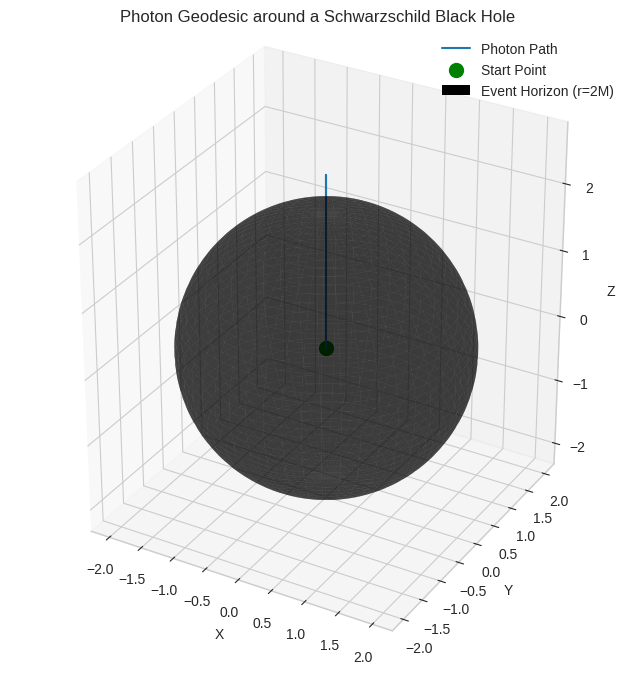

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

# --- 1. Load the Data ---
# Construct the path to the data file relative to the notebook's location.
project_dir = "project"
project_name = "photon_geodesic_integrator"
data_filename = "photon_path.txt"
file_path = os.path.join(project_dir, project_name, data_filename)

# The file has a header, so we skip the first row.
# The data is tab-delimited.
try:
    data = np.loadtxt(file_path, skiprows=1, delimiter='\t')
except FileNotFoundError:
    print(f"Error: Could not find the data file at '{file_path}'")
    print("Please ensure you have run the C code and that the output file exists.")
    # In a notebook, we might not want to exit, so we'll just stop this cell's execution.
    # To do this cleanly, we can raise the error again after printing our helpful message.
    raise 
except Exception as e:
    print(f"An error occurred while reading the file: {e}")
    raise

# Extract columns for clarity
# columns are: lambda_p, t, r, theta, phi, L
r = data[:, 2]
theta = data[:, 3]
phi = data[:, 4]

# --- 2. Convert to Cartesian Coordinates ---
# This is the standard spherical-to-Cartesian transformation
x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r * np.cos(theta)

# --- 3. Create the 3D Plot ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the photon's trajectory
ax.plot(x, y, z, label='Photon Path')

# Mark the starting point of the photon
ax.scatter(x[0], y[0], z[0], color='green', s=100, label='Start Point', zorder=10)

# --- 4. Draw the Black Hole Event Horizon ---
# The event horizon is at r = 2M. Assuming M_scale=1.0 from your project.
M_scale = 1.0
R_horizon = 2 * M_scale

# Create the data for a sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_bh = R_horizon * np.outer(np.cos(u), np.sin(v))
y_bh = R_horizon * np.outer(np.sin(u), np.sin(v))
z_bh = R_horizon * np.outer(np.ones(np.size(u)), np.cos(v))

# Plot the surface of the black hole
ax.plot_surface(x_bh, y_bh, z_bh, color='black', alpha=0.5)

# --- 5. Formatting and Labels ---
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Photon Geodesic around a Schwarzschild Black Hole')

# Set aspect ratio to be equal, so the sphere isn't distorted
ax.set_aspect('equal')

# Add a legend
# Due to a bug in matplotlib for 3D legends, we handle it manually.
bh_proxy = plt.Rectangle((0, 0), 1, 1, fc="black")
handles, labels = ax.get_legend_handles_labels()
handles.append(bh_proxy)
labels.append('Event Horizon (r=2M)')
ax.legend(handles, labels)


plt.show()

# Markdown for generating the disk NumPy array

In [4]:
# Cell for Visualizing/Generating the Unlensed Source Disk (UPDATED with Anti-Aliasing)

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def generate_source_disk_array(
    pixel_width=512,
    disk_physical_width=40.0,
    disk_inner_radius=6.0,
    disk_outer_radius=20.0,
    disk_temp_power_law=-0.75,
    colormap='hot',
    display_image=True
):
    """
    Generates an anti-aliased NumPy array of an accretion disk image.
    """
    # --- 1. Create a Coordinate Grid ---
    half_width = disk_physical_width / 2.0
    y_coords = np.linspace(-half_width, half_width, pixel_width)
    z_coords = np.linspace(-half_width, half_width, pixel_width)
    yy, zz = np.meshgrid(y_coords, z_coords)

    # --- 2. Calculate Physical Properties for Each Pixel ---
    radii = np.sqrt(yy**2 + zz**2)

    # --- 3. Apply the Disk Model with a Smooth Falloff ---
    # Instead of a sharp mask, we'll calculate temperature for all points
    # and then smoothly fade it to zero outside the disk bounds.
    
    # Calculate temperature based on the power law everywhere.
    # Add a small epsilon to radii to avoid division by zero at the center.
    temperature = (radii / disk_inner_radius)**disk_temp_power_law

    # Create a smooth falloff mask using numpy.clip
    # This will create a smooth transition from 1 (inside the disk) to 0 (outside)
    # over a small number of pixels. Let's define a transition width.
    transition_width = 2.0 * (disk_physical_width / pixel_width) # Width of 2 pixels

    # Inner edge falloff
    inner_falloff = np.clip((radii - (disk_inner_radius - transition_width)) / transition_width, 0, 1)
    
    # Outer edge falloff
    outer_falloff = 1.0 - np.clip((radii - disk_outer_radius) / transition_width, 0, 1)

    # Combine the masks and apply to the temperature
    smooth_mask = inner_falloff * outer_falloff
    temperature *= smooth_mask

    # --- 4. Map Temperature to Color and Create Image Array ---
    colormap_func = plt.colormaps[colormap]
    colors = colormap_func(temperature / np.max(temperature)) # Normalize to ensure max is 1
    image_array = (colors[:, :, :3] * 255).astype(np.uint8)
    
    # --- 5. Optionally Display the Image ---
    if display_image:
        print(f"Displaying the unlensed source disk (with anti-aliasing):")
        img = Image.fromarray(image_array)
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.title("Unlensed Source Accretion Disk (Anti-Aliased)")
        plt.show()
        
    # --- 6. Return the NumPy array ---
    return image_array

# Markdown for image genorator

In [29]:
import numpy as np
from PIL import Image
import os
from typing import Optional, List, Union

def render_lensed_image_from_blueprint(
    output_pixel_width: int,
    window_width: float,
    source_image: Union[str, np.ndarray],
    sphere_image: Union[str, np.ndarray],
    source_image_width: float,
    zoom_in_region: Optional[List[float]] = None,
    blueprint_filename: str = "project/photon_geodesic_integrator/blueprint.bin",
    output_filename: str = "lensed_image.png"
) -> None:
    """
    Renders a lensed image using the accumulator/averaging method with a
    correct, parameter-driven physical coordinate mapping that correctly
    handles the background and off-axis sources.
    """
    print("--- Starting Lensed Image Generation (Final Corrected Version) ---")

    # --- 1. Load All Data ---
    if not os.path.exists(blueprint_filename):
        print(f"ERROR: Blueprint file not found.")
        return
    blueprint_dtype = np.dtype([
        ('termination_type', np.int32),
        ('y_w', 'f8'), ('z_w', 'f8'), ('L_w', 'f8'),
        ('y_s', 'f8'), ('z_s', 'f8'), ('L_s', 'f8'),
        ('redshift_ratio', 'f8'),
        ('final_theta', 'f8'), ('final_phi', 'f8')
    ], align=False)
    all_rays = np.fromfile(blueprint_filename, dtype=blueprint_dtype)
    valid_rays = all_rays[np.isfinite(all_rays['y_w']) & np.isfinite(all_rays['z_w'])]
    print(f"Loaded {len(valid_rays)} valid rays from blueprint.")

    if isinstance(source_image, str):
        source_pixels = np.array(Image.open(source_image).convert('RGB'))
    else:
        source_pixels = source_image
    source_pixel_height, source_pixel_width_tex, _ = source_pixels.shape

    if isinstance(sphere_image, str):
        sphere_pixels = np.array(Image.open(sphere_image).convert('RGB'))
    else:
        sphere_pixels = sphere_image
    sphere_pixel_height, sphere_pixel_width_tex, _ = sphere_pixels.shape

    # --- 2. Define the Physical Window and Output Dimensions ---
    if zoom_in_region:
        y_w_min, y_w_max, z_w_min, z_w_max = zoom_in_region
    else:
        # The view is defined by the window_width parameter, centered at (0,0).
        half_width = window_width / 2.0
        y_w_min, y_w_max = -half_width, half_width
        z_w_min, z_w_max = -half_width, half_width

    aspect_ratio = (z_w_max - z_w_min) / (y_w_max - y_w_min)
    output_pixel_height = int(output_pixel_width * aspect_ratio)
    print(f"Output image dimensions: {output_pixel_width} x {output_pixel_height}")

    # --- 3. Prepare Accumulators ---
    rgb_sum_accumulator = np.zeros((output_pixel_height, output_pixel_width, 3), dtype=np.float64)
    hit_count_accumulator = np.zeros((output_pixel_height, output_pixel_width), dtype=np.int32)

    # --- 4. Vectorized Ray-First Processing ---
    # Convert ALL valid ray window coordinates to pixel indices based on the FIXED window size.
    y_w_range = y_w_max - y_w_min
    z_w_range = z_w_max - z_w_min
    
    col_indices = ((valid_rays['y_w'] - y_w_min) / y_w_range * output_pixel_width).astype(int)
    row_indices = ((valid_rays['z_w'] - z_w_min) / z_w_range * output_pixel_height).astype(int)
    row_indices = (output_pixel_height - 1) - row_indices

    # Create a mask for rays that actually fall within our final image canvas.
    # This is the correct way to filter.
    on_canvas_mask = (col_indices >= 0) & (col_indices < output_pixel_width) & \
                     (row_indices >= 0) & (row_indices < output_pixel_height)

    # Use only the rays and their corresponding indices that are on the canvas.
    rays_on_canvas = valid_rays[on_canvas_mask]
    rows_on_canvas = row_indices[on_canvas_mask]
    cols_on_canvas = col_indices[on_canvas_mask]

    # Process each termination type for the on-canvas rays
    failure_mask = rays_on_canvas['termination_type'] == 0
    if np.any(failure_mask):
        np.add.at(hit_count_accumulator, (rows_on_canvas[failure_mask], cols_on_canvas[failure_mask]), 1)

    source_mask = rays_on_canvas['termination_type'] == 1
    if np.any(source_mask):
        source_hits = rays_on_canvas[source_mask]
        
        source_image_height = source_image_width * (source_pixel_height / source_pixel_width_tex)
        half_source_y, half_source_z = source_image_width / 2.0, source_image_height / 2.0

        src_col = ((source_hits['y_s'] + half_source_y) / source_image_width * source_pixel_width_tex).astype(int)
        src_row = ((source_hits['z_s'] + half_source_z) / source_image_height * source_pixel_height).astype(int)
        src_row = (source_pixel_height - 1) - src_row

        on_texture_mask = (src_col >= 0) & (src_col < source_pixel_width_tex) & (src_row >= 0) & (src_row < source_pixel_height)
        
        colors = source_pixels[src_row[on_texture_mask], src_col[on_texture_mask]]
        dest_rows = rows_on_canvas[source_mask][on_texture_mask]
        dest_cols = cols_on_canvas[source_mask][on_texture_mask]

        np.add.at(rgb_sum_accumulator, (dest_rows, dest_cols), colors)
        np.add.at(hit_count_accumulator, (dest_rows, dest_cols), 1)

    sphere_mask = rays_on_canvas['termination_type'] == 2
    if np.any(sphere_mask):
        sphere_hits = rays_on_canvas[sphere_mask]
        
        u = sphere_hits['final_phi'] / (2 * np.pi) + 0.5
        v = sphere_hits['final_theta'] / np.pi
        sphere_col = np.clip(u * sphere_pixel_width_tex, 0, sphere_pixel_width_tex - 1).astype(int)
        sphere_row = np.clip(v * sphere_pixel_height, 0, sphere_pixel_height - 1).astype(int)
        
        colors = sphere_pixels[sphere_row, sphere_col]
        dest_rows = rows_on_canvas[sphere_mask]
        dest_cols = cols_on_canvas[sphere_mask]

        np.add.at(rgb_sum_accumulator, (dest_rows, dest_cols), colors)
        np.add.at(hit_count_accumulator, (dest_rows, dest_cols), 1)

    # --- 5. Final Averaging and Image Creation ---
    output_image = np.zeros((output_pixel_height, output_pixel_width, 3), dtype=np.uint8)
    hit_mask = hit_count_accumulator > 0
    output_image[hit_mask] = (rgb_sum_accumulator[hit_mask] / hit_count_accumulator[hit_mask, np.newaxis]).astype(np.uint8)

    # --- 6. Save Final Image ---
    final_image = Image.fromarray(output_image)
    output_dir = "Generated_nrpy_images"
    os.makedirs(output_dir, exist_ok=True)
    full_path = os.path.join(output_dir, output_filename)
    final_image.save(full_path)
    print(f"--- Image Generation Complete ---")
    print(f"Successfully rendered and saved lensed image to '{full_path}'")

In [24]:
# Final Renderer and Orchestrator Cell (Corrected Horizontal Flip)

import numpy as np
from PIL import Image
import os
import requests

def render_lensed_image_universal(
    output_filename,
    source_image_input,
    sphere_image_filename,
    output_pixel_width=800,
    source_physical_width=40.0,
    blueprint_filename="project/photon_geodesic_integrator/blueprint.bin"
):
    """
    Renders a final lensed image. This version corrects the horizontal axis
    inversion to produce a physically correct orientation.
    """
    # ... (Steps 1, 2, and 3 for loading and setup are the same) ...
    if not os.path.exists(blueprint_filename):
        print(f"ERROR: Blueprint file not found at '{blueprint_filename}'.")
        return
    blueprint_dtype = np.dtype([('termination_type', np.int32), ('y_w', 'f8'), ('z_w', 'f8'), ('L_w', 'f8'), ('y_s', 'f8'), ('z_s', 'f8'), ('L_s', 'f8'), ('redshift_ratio', 'f8'), ('final_theta', 'f8'), ('final_phi', 'f8')], align=False)
    data = np.fromfile(blueprint_filename, dtype=blueprint_dtype)
    valid_mask = np.isfinite(data['y_w']) & np.isfinite(data['z_w'])
    valid_data = data[valid_mask]
    if len(valid_data) == 0: return
    if isinstance(source_image_input, str):
        source_pixels = np.array(Image.open(source_image_input).convert('RGB'))
    else:
        source_pixels = source_image_input
    source_pixel_height, source_pixel_width, _ = source_pixels.shape
    sphere_pixels = np.array(Image.open(sphere_image_filename).convert('RGB'))
    sphere_pixel_height, sphere_pixel_width, _ = sphere_pixels.shape
    output_pixel_height = output_pixel_width
    window_physical_height = window_physical_width = np.max(np.abs(valid_data['y_w'])) * 2.01
    rgb_sum_accumulator = np.zeros((output_pixel_height, output_pixel_width, 3), dtype=np.float64)
    hit_count_accumulator = np.zeros((output_pixel_height, output_pixel_width), dtype=np.int32)

    # --- 4. Map ALL valid window coordinates to output pixels ONCE ---
    # CORRECTED: Flipped the horizontal (column) calculation as well.
    col_out = (output_pixel_width - 1) - ((valid_data['y_w'] + window_physical_width / 2.0) / window_physical_width * (output_pixel_width - 1)).astype(int)
    row_out = (output_pixel_height - 1) - ((valid_data['z_w'] + window_physical_height / 2.0) / window_physical_height * (output_pixel_height - 1)).astype(int)

    # --- 5. Process each termination type using synchronized masks ---
    # ... (The rest of the function is identical to the one you provided, as its logic is sound) ...
    failure_mask = (valid_data['termination_type'] == 0)
    source_mask = (valid_data['termination_type'] == 1)
    sphere_mask = (valid_data['termination_type'] == 2)
    if np.any(failure_mask):
        np.add.at(hit_count_accumulator, (row_out[failure_mask], col_out[failure_mask]), 1)
    if np.any(sphere_mask):
        sphere_hits = valid_data[sphere_mask]
        finite_mask = np.isfinite(sphere_hits['final_phi']) & np.isfinite(sphere_hits['final_theta'])
        if np.any(finite_mask):
            u = sphere_hits['final_phi'][finite_mask] / (2 * np.pi) + 0.5
            v = sphere_hits['final_theta'][finite_mask] / np.pi
            src_col = np.clip(u * sphere_pixel_width, 0, sphere_pixel_width - 1).astype(int)
            src_row = np.clip(v * sphere_pixel_height, 0, sphere_pixel_height - 1).astype(int)
            colors = sphere_pixels[src_row, src_col]
            out_row_masked = row_out[sphere_mask][finite_mask]
            out_col_masked = col_out[sphere_mask][finite_mask]
            np.add.at(rgb_sum_accumulator, (out_row_masked, out_col_masked), colors)
            np.add.at(hit_count_accumulator, (out_row_masked, out_col_masked), 1)
    if np.any(source_mask):
        source_hits = valid_data[source_mask]
        finite_mask = np.isfinite(source_hits['y_s']) & np.isfinite(source_hits['z_s'])
        if np.any(finite_mask):
            source_physical_height = source_physical_width * (source_pixel_height / source_pixel_width)
            src_col = ((source_hits['y_s'][finite_mask] + source_physical_width / 2.0) / source_physical_width * (source_pixel_width - 1)).astype(int)
            src_row = ((source_hits['z_s'][finite_mask] + source_physical_height / 2.0) / source_physical_height * (source_pixel_height - 1)).astype(int)
            on_texture_mask = (src_col >= 0) & (src_col < source_pixel_width) & (src_row >= 0) & (src_row < source_pixel_height)
            colors = source_pixels[src_row[on_texture_mask], src_col[on_texture_mask]]
            out_row_masked = row_out[source_mask][finite_mask][on_texture_mask]
            out_col_masked = col_out[source_mask][finite_mask][on_texture_mask]
            np.add.at(rgb_sum_accumulator, (out_row_masked, out_col_masked), colors)
            np.add.at(hit_count_accumulator, (out_row_masked, out_col_masked), 1)

    # --- 6. Final Image Assembly ---
    print("Averaging colors and constructing final image...")
    hit_pixels_mask = hit_count_accumulator > 0
    output_pixels = np.zeros_like(rgb_sum_accumulator, dtype=np.uint8)
    avg_colors = rgb_sum_accumulator[hit_pixels_mask] / hit_count_accumulator[hit_pixels_mask][:, np.newaxis]
    output_pixels[hit_pixels_mask] = np.clip(avg_colors, 0, 255).astype(np.uint8)

    # --- 7. Save the final image ---
    final_image = Image.fromarray(output_pixels)
    output_dir = "Generated_nrpy_images"
    os.makedirs(output_dir, exist_ok=True)
    full_path = os.path.join(output_dir, output_filename)
    final_image.save(full_path)
    print(f"Successfully rendered and saved lensed image to '{full_path}'")

In [32]:
disk_inner_radius = 0.1
disk_outer_radius= 13.0
disk_temp_power_law=-0.75

procedural_disk_data = generate_source_disk_array(
    pixel_width=2048,
    disk_physical_width=disk_outer_radius,
    disk_inner_radius=disk_inner_radius,
    disk_outer_radius=disk_outer_radius,
    disk_temp_power_law=disk_temp_power_law,
    colormap='hot',
    display_image=False 
)


output_filename= "test_1.png"
output_pixel_width = 400
source_physical_width= 3*disk_outer_radius
sky_map_filename= "starmap_2020.png"
source_image_input= "rainbow.png"


render_lensed_image_universal(
    output_filename=output_filename,
    source_image_input=source_image_input, 
    sphere_image_filename=sky_map_filename,
    output_pixel_width=output_pixel_width,
    source_physical_width=source_physical_width
)

Averaging colors and constructing final image...
Successfully rendered and saved lensed image to 'Generated_nrpy_images/test_1.png'


In [31]:
disk_inner_radius = 0.1
disk_outer_radius= 13.0
disk_temp_power_law=-0.75

procedural_disk_data = generate_source_disk_array(
    pixel_width=2048,
    disk_physical_width=disk_outer_radius,
    disk_inner_radius=disk_inner_radius,
    disk_outer_radius=disk_outer_radius,
    disk_temp_power_law=disk_temp_power_law,
    colormap='hot',
    display_image=False 
)


output_filename= "test.png"
output_pixel_width = 400
window_width= 2
source_image_width= 3*disk_outer_radius
sphere_image= "starmap_2020.png"
source_image= "rainbow.png"
sphere_image = procedural_disk_data

render_lensed_image_from_blueprint(
    output_pixel_width = output_pixel_width,
    window_width = window_width,
    source_image= source_image,
    sphere_image= sphere_image,
    source_image_width= source_image_width,
    output_filename= output_filename
)

--- Starting Lensed Image Generation (Final Corrected Version) ---
Loaded 262144 valid rays from blueprint.
Output image dimensions: 400 x 400
--- Image Generation Complete ---
Successfully rendered and saved lensed image to 'Generated_nrpy_images/test.png'


In [ ]:
print(np.tan(np.pi/180*1)*51)
print(np.tan(np.pi/180*1)*50)

<a id='plot_unlensed'></a>
### 9.c: Unlensed Source Disk Visualizer

This Python cell provides a function, `generate_and_show_source_disk`, to generate and display an image of the source accretion disk as it would appear *without* any gravitational lensing. This serves as a perfect "before" image, providing a clear baseline for comparison with the final, lensed result.

The function works as follows:
1.  **Create Coordinate Grid**: Instead of using ray-traced coordinates, it creates a perfect, uniform 2D grid of `(y, z)` coordinates, representing the source plane.
2.  **Apply Disk Model**: For each point on the grid, it calculates the radial distance from the center. It then uses the user-defined `disk_inner_radius` and `disk_outer_radius` to determine which points lie within the physical disk.
3.  **Calculate Temperature**: For the points inside the disk, it calculates a "temperature" value based on the same power-law profile (`T ∝ r^p`) that will be used in the final renderer. Points outside the disk are assigned a temperature of zero.
4.  **Map to Color**: It uses a `matplotlib` colormap (e.g., `'hot'`) to convert the 2D temperature array into a 2D array of RGB colors.
5.  **Display Image**: Finally, it displays the resulting image directly in the notebook output, providing a clear visualization of the source object's intrinsic appearance.

In [16]:
# Raw Blueprint Data Viewer (FINAL CORRECTED VERSION)

import numpy as np
import os

def view_binary_blueprint(
    blueprint_filename="project/photon_geodesic_integrator/blueprint.bin",
    max_rays_to_print=20
):
    """
    Reads the new binary blueprint file, which includes failure records,
    and prints its raw contents in a human-readable, context-aware format.
    """
    if not os.path.exists(blueprint_filename):
        print(f"Error: Blueprint file not found at '{blueprint_filename}'")
        return

    # This dtype must exactly match the C struct 'blueprint_data_t'
    blueprint_dtype = np.dtype([
        ('termination_type', np.int32),
        ('y_w', 'f8'), ('z_w', 'f8'), ('L_w', 'f8'),
        ('y_s', 'f8'), ('z_s', 'f8'), ('L_s', 'f8'),
        ('redshift_ratio', 'f8'),
        ('final_theta', 'f8'), ('final_phi', 'f8'),
    ], align=False)
    
    data = np.fromfile(blueprint_filename, dtype=blueprint_dtype)
    
    print(f"--- Raw Blueprint Data Inspector ---")
    print(f"Total records read from file: {len(data)}\n")
    print("Printing a sample of records...")
    # CORRECTED: Updated the enum mapping to include FAILURE.
    print("Enum Mapping: 0=FAILURE, 1=SOURCE, 2=SPHERE")
    
    header = f"{'Ray#':<8} | {'TermType':<8} | {'y_w':>8} | {'z_w':>8} | {'y_s / θ':>10} | {'z_s / φ':>10} | {'Redshift':>10}"
    print(header)
    print("-" * len(header))

    if len(data) > max_rays_to_print:
        indices_to_print = np.linspace(0, len(data) - 1, max_rays_to_print, dtype=int)
    else:
        indices_to_print = np.arange(len(data))

    for i in indices_to_print:
        rec = data[i]
        term_type = int(rec['termination_type'])
        # CORRECTED: The list now correctly maps the enum values.
        term_str = ["FAILURE", "SOURCE", "SPHERE"][term_type]

        # CORRECTED: The logic now handles all three cases.
        if term_type == 1: # SOURCE_PLANE
            ys_theta = f"{rec['y_s']:.4f}"
            zs_phi = f"{rec['z_s']:.4f}"
            redshift = f"{rec['redshift_ratio']:.4f}"
        elif term_type == 2: # CELESTIAL_SPHERE
            ys_theta = f"{rec['final_theta']:.4f}"
            zs_phi = f"{rec['final_phi']:.4f}"
            redshift = "N/A"
        else: # FAILURE
            ys_theta = "N/A"
            zs_phi = "N/A"
            redshift = "N/A"
        
        print(f"{i:<8} | {term_str:<8} | {rec['y_w']:>8.2f} | {rec['z_w']:>8.2f} | {ys_theta:>10} | {zs_phi:>10} | {redshift:>10}")

# --- Run the viewer ---
view_binary_blueprint()

--- Raw Blueprint Data Inspector ---
Total records read from file: 262144

Printing a sample of records...
Enum Mapping: 0=FAILURE, 1=SOURCE, 2=SPHERE
Ray#     | TermType |      y_w |      z_w |    y_s / θ |    z_s / φ |   Redshift
--------------------------------------------------------------------------------
0        | SPHERE   |    -0.99 |    -0.99 |     2.4140 |    -0.7854 |        N/A
13797    | SPHERE   |     0.89 |    -0.89 |     2.4848 |    -2.3562 |        N/A
27594    | SPHERE   |     0.79 |    -0.79 |     2.5703 |    -2.3562 |        N/A
41391    | SOURCE   |     0.68 |    -0.68 |    -1.4647 |   -11.4647 |     0.0000
55188    | SOURCE   |     0.58 |    -0.58 |     0.2641 |    -9.7359 |     0.0000
68985    | SOURCE   |     0.47 |    -0.47 |     2.0359 |    -7.9641 |     0.0000
82782    | SOURCE   |     0.37 |    -0.37 |     3.8516 |    -6.1484 |     0.0000
96579    | SOURCE   |     0.26 |    -0.26 |     5.7105 |    -4.2895 |     0.0000
110376   | SOURCE   |     0.16 |    -0.

<a id='plot_lensed'></a>
### 9.d: Final Lensed Image Renderer

This is the final step in the workflow. This Python cell contains the function `render_accretion_disk`, which takes the geometric data from the `blueprint.bin` file and the physical parameters of a source object (the accretion disk) to generate the final, gravitationally lensed image.

This function demonstrates the power of decoupling the geometry from the rendering. The `blueprint.bin` file is a reusable map of the spacetime's lensing properties. This renderer then "paints" a source onto that map.

The rendering process is as follows:
1.  **Load Blueprint Data**: It reads the `blueprint.bin` file into a structured NumPy array.
2.  **Filter for Disk Hits**: It calculates the source-plane radius `r_s` for each successful ray. It then applies a filter to keep only the rays whose `r_s` falls within the specified `disk_inner_radius` and `disk_outer_radius` of the physical disk being rendered.
3.  **Calculate Observed Temperature**: For each valid ray, it performs the core physics calculation:
    a.  The **source temperature** is calculated based on the hit radius `r_s` and the `disk_temp_power_law`.
    b.  The **observed temperature** is then found by multiplying the source temperature by the `redshift_ratio` stored in the blueprint. This single step correctly accounts for gravitational redshift, Doppler beaming, and other relativistic effects.
4.  **Map to Color**: The calculated observed temperature for each ray is mapped to an RGB color using a specified colormap.
5.  **Create Image**: An empty image array is created. The function then iterates through the valid rays, using the window coordinates `(y_w, z_w)` to determine the correct pixel location, and "paints" the calculated color at that pixel.
6.  **Save Image**: The final image array is saved to a file (e.g., `schwarzschild_disk.png`).

# Markdown for running image code

# Markdwon for blueprint stats detail

--- Blueprint File Analysis ---
Total rays in scan: 262144
  Rays that hit the source plane:      98856 (37.71%)
  Rays that hit the celestial sphere:  158112 (60.31%)
  Rays that failed (e.g., hit shadow): 5176 (1.97%)
-----------------------------------

--- Window Plane Coordinate Statistics (y_w, z_w) ---
  y_w min: -0.994, max: 0.994, mean: 0.000
  z_w min: -0.994, max: 0.994, mean: -0.000

--- Source Plane Hit Statistics (y_s, z_s) ---
  y_s min: -12.146, max: 12.988, mean: 1.869
  z_s min: -12.974, max: 12.974, mean: 0.000
  Planar Radius (r_s) min: 0.044, max: 13.000


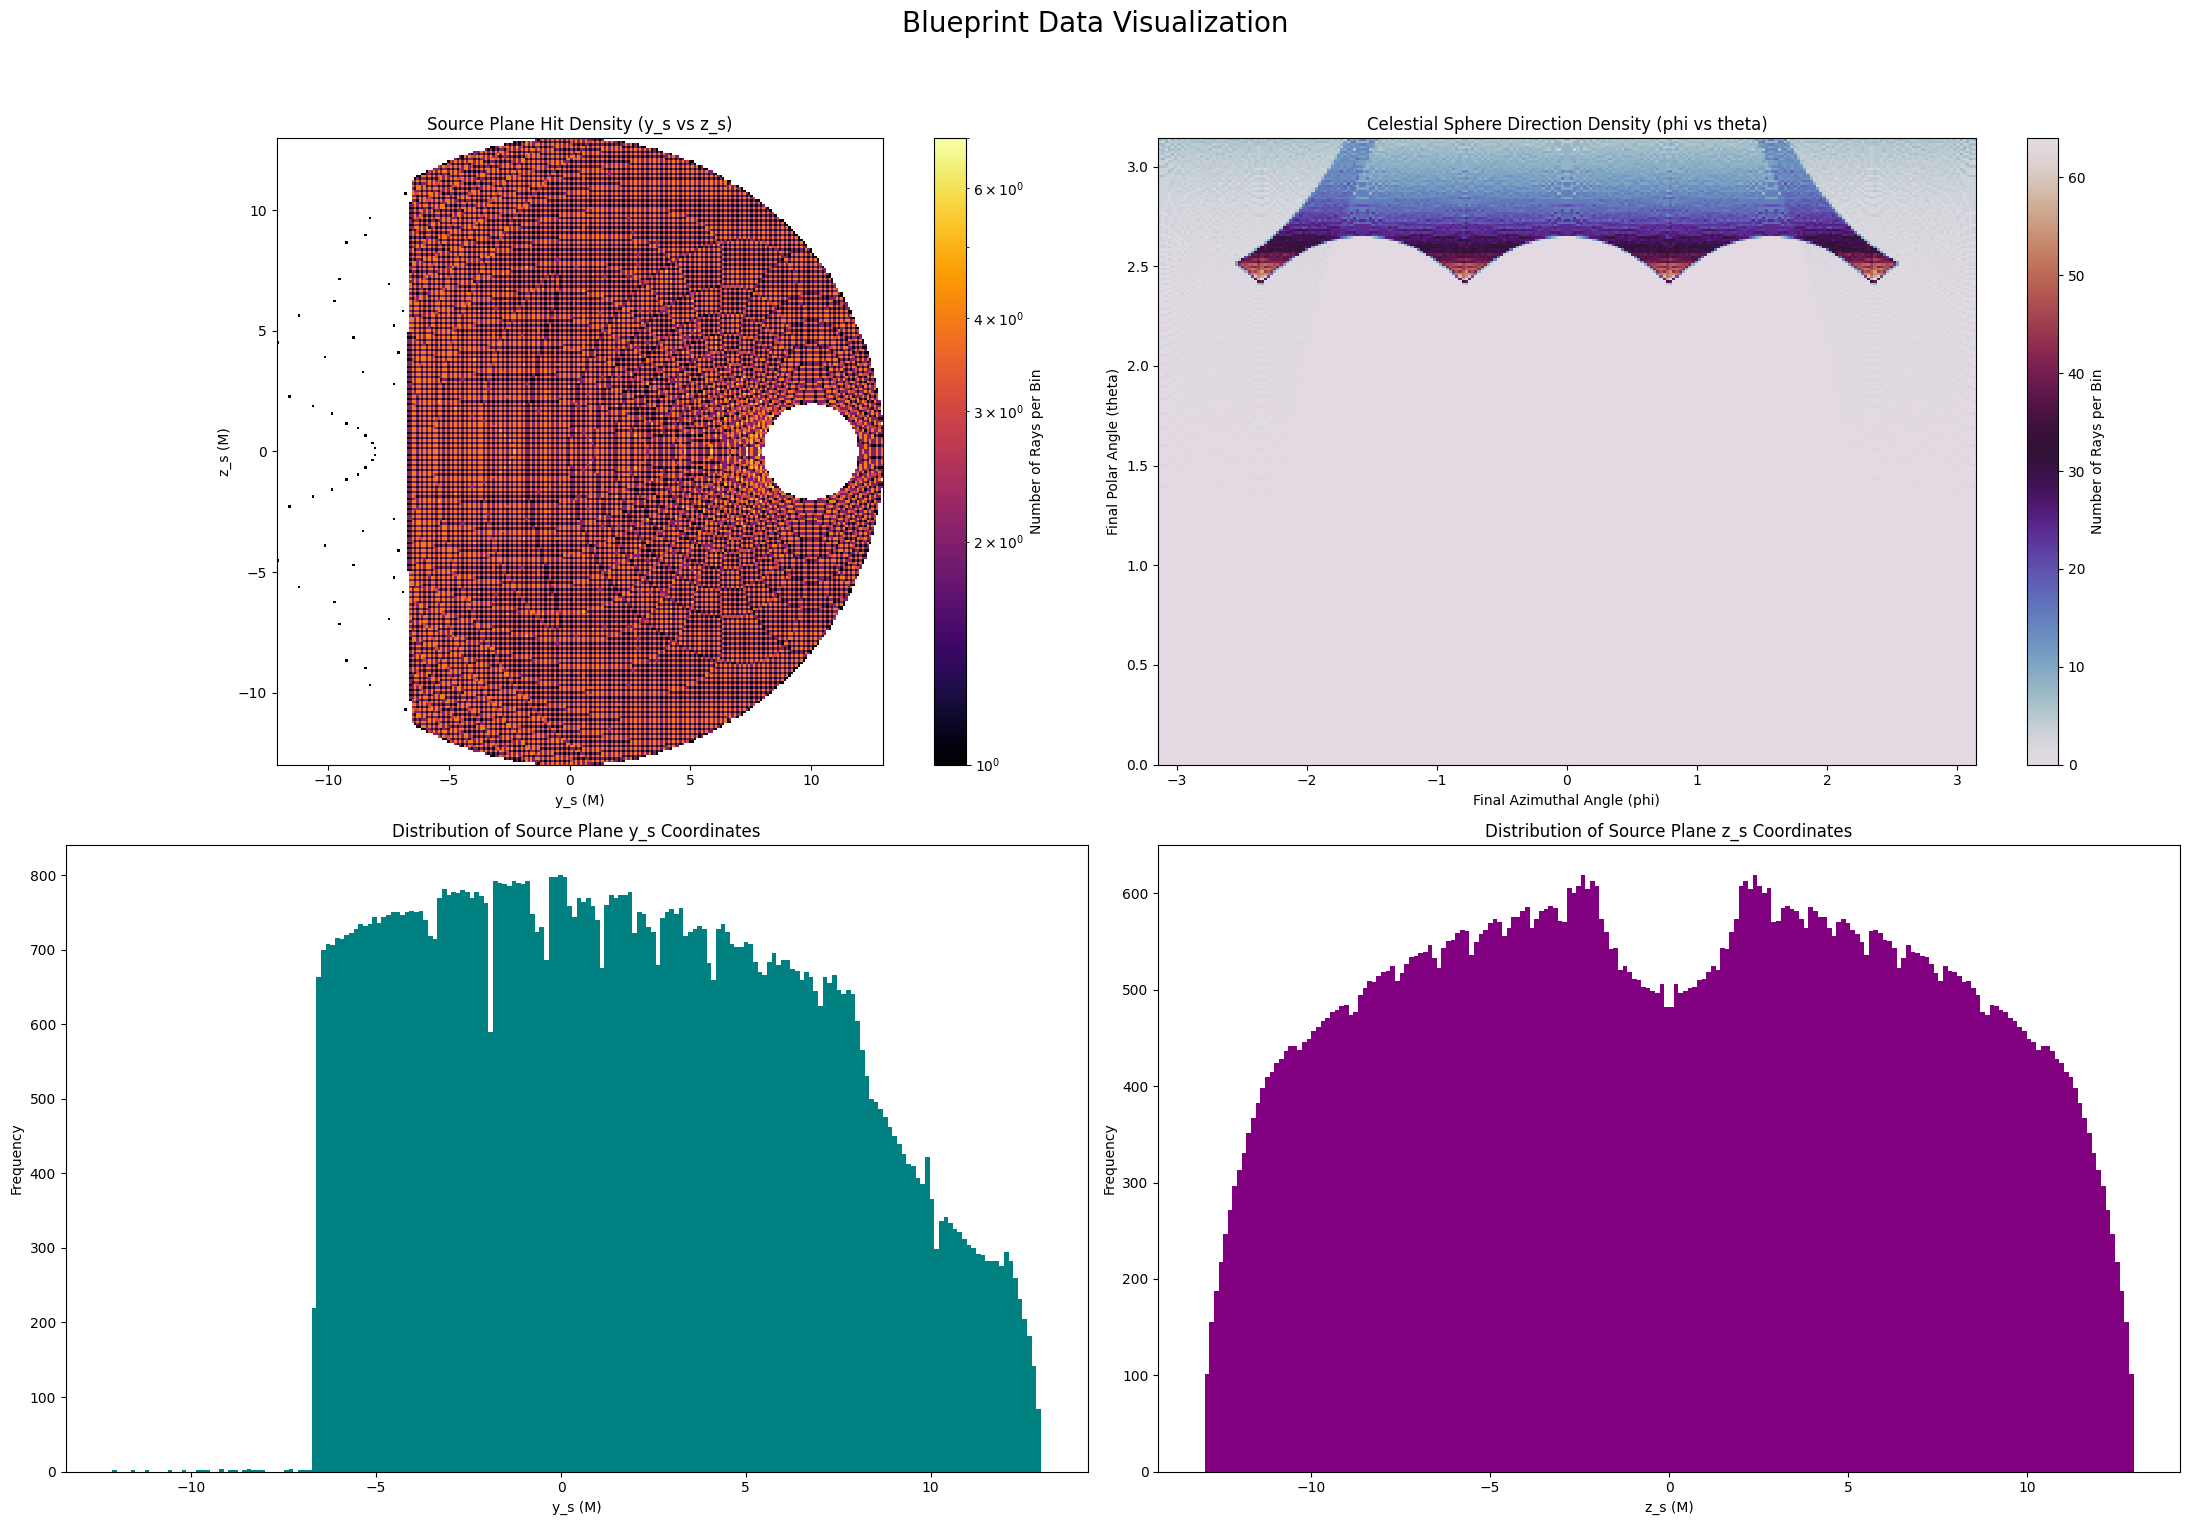

In [18]:
# In file: V10_Python_to_C_via_NRPy.ipynb
# In cell [07bf54b4]

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os

def analyze_blueprint(blueprint_filename="project/photon_geodesic_integrator/blueprint.bin"):
    """
    Reads the blueprint file and generates enhanced statistical analysis and plots,
    including 1D histograms for source hit coordinates.
    """
    # --- 1. Load Data ---
    if not os.path.exists(blueprint_filename):
        print(f"Error: Blueprint file not found at '{blueprint_filename}'")
        return

    blueprint_dtype = np.dtype([
        ('termination_type', np.int32),
        ('y_w', 'f8'), ('z_w', 'f8'), ('L_w', 'f8'),
        ('y_s', 'f8'), ('z_s', 'f8'), ('L_s', 'f8'),
        ('redshift_ratio', 'f8'),
        ('final_theta', 'f8'), ('final_phi', 'f8'),
    ], align=False)

    data = np.fromfile(blueprint_filename, dtype=blueprint_dtype)
    if len(data) == 0:
        print("Blueprint file is empty. No analysis to perform.")
        return

    # --- 2. Segregate Data by Termination Type ---
    failure_hits = data[data['termination_type'] == 0]
    source_hits = data[data['termination_type'] == 1]
    sphere_hits = data[data['termination_type'] == 2]
    
    num_total_rays = len(data)
    num_failure_hits = len(failure_hits)
    num_source_hits = len(source_hits)
    num_sphere_hits = len(sphere_hits)

    print("--- Blueprint File Analysis ---")
    print(f"Total rays in scan: {num_total_rays}")
    print(f"  Rays that hit the source plane:      {num_source_hits} ({100.0 * num_source_hits / num_total_rays:.2f}%)")
    print(f"  Rays that hit the celestial sphere:  {num_sphere_hits} ({100.0 * num_sphere_hits / num_total_rays:.2f}%)")
    print(f"  Rays that failed (e.g., hit shadow): {num_failure_hits} ({100.0 * num_failure_hits / num_total_rays:.2f}%)")
    print("-" * 35)

    # --- 3. Analyze All Coordinate Ranges ---
    valid_hits = data[np.isfinite(data['y_w'])]
    if len(valid_hits) > 0:
        print("\n--- Window Plane Coordinate Statistics (y_w, z_w) ---")
        print(f"  y_w min: {np.min(valid_hits['y_w']):.3f}, max: {np.max(valid_hits['y_w']):.3f}, mean: {np.mean(valid_hits['y_w']):.3f}")
        print(f"  z_w min: {np.min(valid_hits['z_w']):.3f}, max: {np.max(valid_hits['z_w']):.3f}, mean: {np.mean(valid_hits['z_w']):.3f}")

    # --- 4. Analyze Source Plane Hits ---
    if num_source_hits > 0:
        finite_source_mask = np.isfinite(source_hits['y_s']) & np.isfinite(source_hits['z_s'])
        finite_source_hits = source_hits[finite_source_mask]
        
        if len(finite_source_hits) > 0:
            r_s = np.sqrt(finite_source_hits['y_s']**2 + finite_source_hits['z_s']**2)
            print("\n--- Source Plane Hit Statistics (y_s, z_s) ---")
            print(f"  y_s min: {np.min(finite_source_hits['y_s']):.3f}, max: {np.max(finite_source_hits['y_s']):.3f}, mean: {np.mean(finite_source_hits['y_s']):.3f}")
            print(f"  z_s min: {np.min(finite_source_hits['z_s']):.3f}, max: {np.max(finite_source_hits['z_s']):.3f}, mean: {np.mean(finite_source_hits['z_s']):.3f}")
            print(f"  Planar Radius (r_s) min: {np.min(r_s):.3f}, max: {np.max(r_s):.3f}")
    
    # --- 5. Generate Plots ---
    # Create a 2x2 grid for more detailed plots
    fig, axes = plt.subplots(2, 2, figsize=(22, 16))
    fig.suptitle("Blueprint Data Visualization", fontsize=20)
    
    # Plot 1: Source Plane Hit Density
    if num_source_hits > 0 and 'finite_source_hits' in locals() and len(finite_source_hits) > 0:
        hist = axes[0, 0].hist2d(finite_source_hits['y_s'], finite_source_hits['z_s'], bins=256, cmap='inferno', norm=LogNorm())
        axes[0, 0].set_title("Source Plane Hit Density (y_s vs z_s)")
        axes[0, 0].set_xlabel("y_s (M)")
        axes[0, 0].set_ylabel("z_s (M)")
        axes[0, 0].set_aspect('equal', 'box')
        fig.colorbar(hist[3], ax=axes[0, 0], label="Number of Rays per Bin")

    # Plot 2: Celestial Sphere Direction Density
    if num_sphere_hits > 0:
        finite_sphere_mask = np.isfinite(sphere_hits['final_theta']) & np.isfinite(sphere_hits['final_phi'])
        finite_sphere_hits = sphere_hits[finite_sphere_mask]
        if len(finite_sphere_hits) > 0:
            hist2 = axes[0, 1].hist2d(finite_sphere_hits['final_phi'], finite_sphere_hits['final_theta'], bins=256, cmap='twilight', range=[[-np.pi, np.pi], [0, np.pi]])
            axes[0, 1].set_title("Celestial Sphere Direction Density (phi vs theta)")
            axes[0, 1].set_xlabel("Final Azimuthal Angle (phi)")
            axes[0, 1].set_ylabel("Final Polar Angle (theta)")
            fig.colorbar(hist2[3], ax=axes[0, 1], label="Number of Rays per Bin")

    # Plot 3 & 4: 1D Histograms for y_s and z_s
    if num_source_hits > 0 and 'finite_source_hits' in locals() and len(finite_source_hits) > 0:
        axes[1, 0].hist(finite_source_hits['y_s'], bins=200, color='teal')
        axes[1, 0].set_title("Distribution of Source Plane y_s Coordinates")
        axes[1, 0].set_xlabel("y_s (M)")
        axes[1, 0].set_ylabel("Frequency")

        axes[1, 1].hist(finite_source_hits['z_s'], bins=200, color='purple')
        axes[1, 1].set_title("Distribution of Source Plane z_s Coordinates")
        axes[1, 1].set_xlabel("z_s (M)")
        axes[1, 1].set_ylabel("Frequency")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Run the analysis
analyze_blueprint()

# Markdown for disk generation

In [ ]:
# V9_Python_to_C_via_NRPy.ipynb Cell
#
# Cell for Procedural Accretion Disk Rendering (Version 2)
# This version uses the modern matplotlib API to avoid deprecation warnings.

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt # Changed from matplotlib.cm to the main pyplot
import os

def render_accretion_disk(
    output_filename="accretion_disk.png",
    blueprint_filename="project/photon_geodesic_integrator/blueprint.bin",
    output_pixel_width=512,
    window_physical_width=25.0,
    disk_inner_radius=6.0,
    disk_outer_radius=20.0,
    disk_temp_power_law=-0.75,
    colormap='hot'
):
    """
    Renders a lensed accretion disk from a binary blueprint file.
    """
    # --- 1. Load Blueprint Data ---
    if not os.path.exists(blueprint_filename):
        print(f"Error: Blueprint file not found at '{blueprint_filename}'")
        return

    blueprint_dtype = np.dtype([
        ('found', '?'),
        ('y_w', 'f8'), ('z_w', 'f8'), ('L_w', 'f8'),
        ('y_s', 'f8'), ('z_s', 'f8'), ('L_s', 'f8'),
        ('redshift_ratio', 'f8')
    ], align=False)

    data = np.fromfile(blueprint_filename, dtype=blueprint_dtype)
    found_data = data[data['found']]

    if len(found_data) == 0:
        print("No valid ray data in blueprint. Cannot render.")
        return

    # --- 2. Filter for Rays Hitting the Physical Disk ---
    y_s = found_data['y_s']
    z_s = found_data['z_s']
    r_s = np.sqrt(y_s**2 + z_s**2)
    
    disk_mask = (r_s >= disk_inner_radius) & (r_s <= disk_outer_radius)
    
    disk_y_w = found_data['y_w'][disk_mask]
    disk_z_w = found_data['z_w'][disk_mask]
    disk_r_s = r_s[disk_mask]
    disk_redshift = found_data['redshift_ratio'][disk_mask]

    # --- 3. Calculate Observed Temperature and Map to Color ---
    T_source_norm = (disk_r_s / disk_inner_radius)**disk_temp_power_law
    T_observed_norm = T_source_norm * disk_redshift
    
    # CORRECTED: Use the modern, recommended way to get a colormap
    colormap_func = plt.colormaps[colormap]
    
    vmax = np.percentile(T_observed_norm, 99.5)
    norm_colors = T_observed_norm / vmax
    
    colors = colormap_func(np.clip(norm_colors, 0, 1))
    colors_uint8 = (colors[:, :3] * 255).astype(np.uint8)

    # --- 4. Map Window Coordinates to Pixels and Create Image ---
    output_pixel_height = int(output_pixel_width) # Assume square
    image_array = np.zeros((output_pixel_height, output_pixel_width, 3), dtype=np.uint8)
    
    half_width = window_physical_width / 2.0
    col_idx = ((disk_y_w + half_width) / window_physical_width * (output_pixel_width - 1)).astype(int)
    row_idx = ((disk_z_w + half_width) / window_physical_width * (output_pixel_height - 1)).astype(int)
    
    valid_indices = (col_idx >= 0) & (col_idx < output_pixel_width) & \
                    (row_idx >= 0) & (row_idx < output_pixel_height)

    image_array[row_idx[valid_indices], col_idx[valid_indices]] = colors_uint8[valid_indices]

    # --- 5. Save the Final Image ---
    img = Image.fromarray(image_array)
    img.save(output_filename)
    print(f"Successfully rendered accretion disk to '{output_filename}'")


# --- Run the renderer with desired parameters ---
render_accretion_disk(
    output_filename="kerr_disk.png",
    window_physical_width=0.75,
    disk_inner_radius=6.0,
    disk_outer_radius=25.0,
    colormap='hot',
    output_pixel_width=900
)

# Markdown for undistored disk

In [ ]:
# Cell for Visualizing the Unlensed Source Disk (with Anti-Aliasing)

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def generate_and_show_source_disk(
    pixel_width=512,
    disk_physical_width=40.0,
    disk_inner_radius=6.0,
    disk_outer_radius=20.0,
    disk_temp_power_law=-0.75,
    colormap='hot'
):
    """
    Generates and displays an image of the unlensed accretion disk
    with smooth, anti-aliased edges.
    """
    # --- 1. Create a Coordinate Grid ---
    # Create a grid of (y, z) coordinates that represents the source plane.
    half_width = disk_physical_width / 2.0
    y_coords = np.linspace(-half_width, half_width, pixel_width)
    z_coords = np.linspace(-half_width, half_width, pixel_width)
    yy, zz = np.meshgrid(y_coords, z_coords)

    # --- 2. Calculate Physical Properties for Each Pixel ---
    # Calculate the cylindrical radius for every point on the grid.
    radii = np.sqrt(yy**2 + zz**2)

    # --- 3. Apply the Disk Model with a Smooth Falloff (Anti-Aliasing) ---
    # Calculate temperature based on the power law everywhere.
    # Add a small epsilon to radii to avoid division by zero at the center.
    temperature = (radii / disk_inner_radius)**disk_temp_power_law

    # Create a smooth falloff mask. The transition width is set to be
    # equivalent to a few pixels for a smooth but not overly blurry edge.
    transition_width = 2.0 * (disk_physical_width / pixel_width)

    # Inner edge falloff (from 0 to 1)
    inner_falloff = np.clip((radii - (disk_inner_radius - transition_width)) / transition_width, 0, 1)
    
    # Outer edge falloff (from 1 to 0)
    outer_falloff = 1.0 - np.clip((radii - disk_outer_radius) / transition_width, 0, 1)

    # Combine the masks and apply to the temperature
    smooth_mask = inner_falloff * outer_falloff
    temperature *= smooth_mask
    
    # Set any invalid numbers (from 0**negative_power) to zero
    temperature[np.isnan(temperature)] = 0

    # --- 4. Map Temperature to Color and Create Image Array ---
    # Get the colormap function.
    colormap_func = plt.colormaps[colormap]
    
    # Normalize temperature to the range [0, 1] for the colormap
    # and map the values to RGBA colors.
    colors = colormap_func(temperature / np.max(temperature))
    
    # Convert from float [0,1] to uint8 [0,255] for image display.
    image_array = (colors[:, :, :3] * 255).astype(np.uint8)

    # --- 5. Display the Image ---
    print(f"Displaying the unlensed source disk:")
    print(f"  Physical Width: {disk_physical_width} M")
    print(f"  Inner Radius:   {disk_inner_radius} M")
    print(f"  Outer Radius:   {disk_outer_radius} M")
    
    img = Image.fromarray(image_array)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title("Unlensed Source Accretion Disk")
    plt.xlabel("y_s (pixels)")
    plt.ylabel("z_s (pixels)")
    plt.show()


# --- Generate and show the disk with typical parameters ---
generate_and_show_source_disk(
    pixel_width=1024,
    disk_physical_width=40.0, # A reasonable viewing area
    disk_inner_radius=6.0,
    disk_outer_radius=20.0,
    colormap='hot'
)

In [ ]:
# V9_Python_to_C_via_NRPy.ipynb Cell
#
# Cell for Visualizing the 3D Scene Geometry (NumPy 2.0 Compatible)
# This function parses the C program's command-line arguments and
# creates a 3D plot of the camera, window, and source plane setup.

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

# Helper class for drawing 3D arrows, which matplotlib lacks by default.
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        return np.min(zs3d)

def visualize_scene_from_cmdline(cmd_string):
    """
    Parses a command-line string and creates a 3D visualization of the scene.
    """
    # --- 1. Parse the Command-Line String ---
    parts = cmd_string.split()
    
    # Map parts to named variables for clarity, skipping unused ones
    camera_pos_x = float(parts[2])
    camera_pos_y = float(parts[3])
    camera_pos_z = float(parts[4])
    
    window_center_x = float(parts[5])
    window_center_y = float(parts[6])
    window_center_z = float(parts[7])
    
    source_plane_normal_x = float(parts[8])
    source_plane_normal_y = float(parts[9])
    source_plane_normal_z = float(parts[10])
    
    source_plane_center_x = float(parts[11])
    source_plane_center_y = float(parts[12])
    source_plane_center_z = float(parts[13])
    
    source_up_vec_x = float(parts[14])
    source_up_vec_y = float(parts[15])
    source_up_vec_z = float(parts[16])
    
    window_size = float(parts[20])

    # Convert to numpy arrays for vector math
    camera_pos = np.array([camera_pos_x, camera_pos_y, camera_pos_z])
    window_center = np.array([window_center_x, window_center_y, window_center_z])
    source_center = np.array([source_plane_center_x, source_plane_center_y, source_plane_center_z])
    source_normal = np.array([source_plane_normal_x, source_plane_normal_y, source_plane_normal_z])
    source_up = np.array([source_up_vec_x, source_up_vec_y, source_up_vec_z])

    # --- 2. Setup the 3D Plot ---
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter([0], [0], [0], color='black', s=200, label='Black Hole (Origin)')

    # --- 3. Plot Camera and Window ---
    ax.scatter(*camera_pos, color='blue', s=100, label='Camera Position')
    ax.scatter(*window_center, color='cyan', s=50, label='Window Center')

    cam_view_vec = window_center - camera_pos
    cam_view_vec /= np.linalg.norm(cam_view_vec)
    
    temp_up = np.array([0, 0, 1])
    if np.abs(np.dot(cam_view_vec, temp_up)) > 0.99:
        temp_up = np.array([0, 1, 0])
        
    win_x_vec = np.cross(temp_up, cam_view_vec)
    win_x_vec /= np.linalg.norm(win_x_vec)
    win_y_vec = np.cross(cam_view_vec, win_x_vec)

    half_win = window_size / 2.0
    win_xx, win_yy = np.meshgrid(np.linspace(-half_win, half_win, 5), np.linspace(-half_win, half_win, 5))
    win_plane = window_center[:, np.newaxis, np.newaxis] + \
                win_x_vec[:, np.newaxis, np.newaxis] * win_xx + \
                win_y_vec[:, np.newaxis, np.newaxis] * win_yy
    ax.plot_surface(win_plane[0], win_plane[1], win_plane[2], color='cyan', alpha=0.2, label='Window Plane')
    
    # --- 4. Plot Source Plane ---
    ax.scatter(*source_center, color='red', s=50, label='Source Center')
    
    src_x_vec = np.cross(source_up, source_normal)
    src_x_vec /= np.linalg.norm(src_x_vec)
    src_y_vec = np.cross(source_normal, src_x_vec)

    src_vis_size = 30
    src_xx, src_yy = np.meshgrid(np.linspace(-src_vis_size, src_vis_size, 10), np.linspace(-src_vis_size, src_vis_size, 10))
    src_plane = source_center[:, np.newaxis, np.newaxis] + \
                src_x_vec[:, np.newaxis, np.newaxis] * src_xx + \
                src_y_vec[:, np.newaxis, np.newaxis] * src_yy
    ax.plot_surface(src_plane[0], src_plane[1], src_plane[2], color='red', alpha=0.2, label='Source Plane')

    # --- 5. Plot Vectors ---
    arrow = Arrow3D([camera_pos[0], window_center[0]], [camera_pos[1], window_center[1]], [camera_pos[2], window_center[2]],
                    mutation_scale=20, lw=2, arrowstyle="-|>", color="blue")
    ax.add_artist(arrow)
    ax.text(*(window_center * 1.05), "View Vec", color="blue")

    arrow = Arrow3D([source_center[0], source_center[0] + source_normal[0]*10],
                    [source_center[1], source_center[1] + source_normal[1]*10],
                    [source_center[2], source_center[2] + source_normal[2]*10],
                    mutation_scale=20, lw=2, arrowstyle="-|>", color="red")
    ax.add_artist(arrow)
    ax.text(*(source_center + source_normal*11), "Normal Vec", color="red")

    arrow = Arrow3D([source_center[0], source_center[0] + source_up[0]*10],
                    [source_center[1], source_center[1] + source_up[1]*10],
                    [source_center[2], source_center[2] + source_up[2]*10],
                    mutation_scale=20, lw=2, arrowstyle="-|>", color="green")
    ax.add_artist(arrow)
    ax.text(*(source_center + source_up*11), "Up Vec", color="green")
    
    # --- 6. Formatting ---
    ax.set_xlabel("X (M)")
    ax.set_ylabel("Y (M)")
    ax.set_zlabel("Z (M)")
    ax.set_title("3D Scene Geometry Visualization")
    
    # Set aspect ratio to be equal
    # CORRECTED: Use np.ptp() instead of the removed ndarray.ptp() method.
    max_range = np.ptp(np.array([ax.get_xlim(), ax.get_ylim(), ax.get_zlim()]), axis=1).max()
    mid_x = np.mean(ax.get_xlim())
    mid_y = np.mean(ax.get_ylim())
    mid_z = np.mean(ax.get_zlim())
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)
    
    ax.legend()
    plt.show()


# --- Call the function with your command-line string ---
cmd_line = "1.000 0.000 101.000 0.000 1.000 100.000 0.000 0.990 0.000 0.000 1.000 0.000 0.000 0.000 -1.000 0.000 0.000 6.000 60.000 1024 10.0000"
visualize_scene_from_cmdline(cmd_line)

# Markdown for start of new image generation code

In [33]:
# %%
### Cell 1: Imports and Global Definitions
# This cell imports all required libraries and defines the data structure
# for the blueprint file. Run this cell first.

import numpy as np
from PIL import Image
from typing import Union, Optional, List, Tuple
import os

# Define the exact structure of a record in the blueprint.bin file
# This must match the C struct 'blueprint_data_t'
BLUEPRINT_DTYPE = np.dtype([
    ('termination_type', np.int32),
    ('y_w', 'f8'), ('z_w', 'f8'), ('L_w', 'f8'),
    ('y_s', 'f8'), ('z_s', 'f8'), ('L_s', 'f8'),
    ('redshift_ratio', 'f8'),
    ('final_theta', 'f8'), ('final_phi', 'f8'),
], align=False)

print("Libraries and blueprint data type defined.")

Libraries and blueprint data type defined.


In [34]:
# %%
### Cell 2: Helper Function to Load Textures
# This function handles loading images from a file path or using a
# pre-loaded NumPy array.

def _load_texture(image_input: Union[str, np.ndarray]) -> np.ndarray:
    """Helper function to load an image or use a pre-loaded numpy array."""
    if isinstance(image_input, str):
        if not os.path.exists(image_input):
            raise FileNotFoundError(f"Texture file not found: {image_input}")
        with Image.open(image_input) as img:
            # Convert to RGB and normalize to [0.0, 1.0] floats
            return np.array(img.convert("RGB")) / 255.0
    elif isinstance(image_input, np.ndarray):
        return image_input
    else:
        raise TypeError("Image input must be a file path (str) or a NumPy array.")

print("Helper function `_load_texture` defined.")

Helper function `_load_texture` defined.


In [35]:
# %%
### Cell 3: Main Image Generation Function
# This cell defines the primary function that reads the blueprint, processes
# all the ray data, and generates the final lensed image.

def generate_lensed_image(
    output_filename: str,
    output_pixel_width: int,
    source_image_width: float,
    sphere_image: Union[str, np.ndarray],
    source_image: Union[str, np.ndarray],
    blueprint_filename: str = "blueprint.bin",
    window_width: Optional[float] = None,
    zoom_region: Optional[Union[List[float], Tuple[float, float, float, float]]] = None
) -> None:
    """
    Generates a lensed image from a general relativistic ray-tracing blueprint.

    This function uses a high-performance vectorized NumPy approach to process
    all photons simultaneously, accumulating their color contributions to render
    a final, anti-aliased image.

    Args:
        output_filename: Path to save the final .png image.
        output_pixel_width: The width of the output image in pixels.
        source_image_width: The physical width (and height) of the source
                            plane in the simulation's local (y_s, z_s) coordinates.
        sphere_image: Path to the celestial sphere background image or a
                      pre-loaded NumPy array (equirectangular projection).
        source_image: Path to the source texture image (e.g., accretion disk)
                      or a pre-loaded NumPy array.
        blueprint_filename: Path to the input 'blueprint.bin' file.
        window_width: Physical width of a square, centered viewing window.
                      Used if 'zoom_region' is not provided.
        zoom_region: A list or tuple [y_min, y_max, z_min, z_max] defining a
                     precise, non-centered viewing window. Takes precedence.
    """
    print("--- Starting Lensed Image Generation ---")

    # --- Phase 1: Initialization and Setup ---
    print("1. Initializing and loading data...")

    if zoom_region:
        y_w_min, y_w_max, z_w_min, z_w_max = zoom_region
    elif window_width:
        half_w = window_width / 2.0
        y_w_min, y_w_max = -half_w, half_w
        z_w_min, z_w_max = -half_w, half_w
    else:
        raise ValueError("Either 'window_width' or 'zoom_region' must be provided.")

    window_y_range = y_w_max - y_w_min
    window_z_range = z_w_max - z_w_min
    if window_y_range <= 0 or window_z_range <= 0:
        raise ValueError("Window ranges must be positive.")

    aspect_ratio = window_z_range / window_y_range
    output_pixel_height = int(output_pixel_width * aspect_ratio)

    # Load textures into normalized float arrays
    source_texture = _load_texture(source_image)
    sphere_texture = _load_texture(sphere_image)
    source_pixel_height, source_pixel_width, _ = source_texture.shape
    sphere_pixel_height, sphere_pixel_width, _ = sphere_texture.shape

    # Load blueprint data
    if not os.path.exists(blueprint_filename):
        raise FileNotFoundError(f"Blueprint file not found: {blueprint_filename}")
    blueprint_data = np.fromfile(blueprint_filename, dtype=BLUEPRINT_DTYPE)
    print(f"   Loaded {len(blueprint_data)} records from blueprint.")

    # Initialize accumulator arrays
    pixel_accumulator = np.zeros((output_pixel_height, output_pixel_width, 3), dtype=np.float64)
    count_accumulator = np.zeros((output_pixel_height, output_pixel_width), dtype=np.int32)

    # --- Phase 2: Vectorized Ray Processing ---
    print("2. Processing rays with vectorized operations...")

    mask_in_view = (
        (blueprint_data['y_w'] >= y_w_min) & (blueprint_data['y_w'] < y_w_max) &
        (blueprint_data['z_w'] >= z_w_min) & (blueprint_data['z_w'] < z_w_max)
    )
    rays_in_view = blueprint_data[mask_in_view]
    
    if len(rays_in_view) == 0:
        print("Warning: No rays from the blueprint were found within the specified window.")
    else:
        print(f"   {len(rays_in_view)} rays are within the viewing window.")

        px_float = (rays_in_view['y_w'] - y_w_min) / window_y_range * output_pixel_width
        py_float = (z_w_max - rays_in_view['z_w']) / window_z_range * (output_pixel_height - 1)

        px = np.clip(px_float, 0, output_pixel_width - 1).astype(np.int32)
        py = np.clip(py_float, 0, output_pixel_height - 1).astype(np.int32)

        is_source = rays_in_view['termination_type'] == 1
        is_sphere = rays_in_view['termination_type'] == 2

        if np.any(is_source):
            source_hits = rays_in_view[is_source]
            half_sw = source_image_width / 2.0
            norm_y = (source_hits['y_s'] + half_sw) / source_image_width
            norm_z = (source_hits['z_s'] + half_sw) / source_image_width
            px_s = norm_y * (source_pixel_width - 1)
            py_s = (1.0 - norm_z) * (source_pixel_height - 1)
            px_s_int = np.clip(px_s, 0, source_pixel_width - 1).astype(np.int32)
            py_s_int = np.clip(py_s, 0, source_pixel_height - 1).astype(np.int32)
            source_colors = source_texture[py_s_int, px_s_int]
            np.add.at(pixel_accumulator, (py[is_source], px[is_source]), source_colors)

        if np.any(is_sphere):
            sphere_hits = rays_in_view[is_sphere]
            norm_phi = (sphere_hits['final_phi'] + np.pi) / (2 * np.pi)
            norm_theta = sphere_hits['final_theta'] / np.pi
            px_sph = norm_phi * (sphere_pixel_width - 1)
            py_sph = norm_theta * (sphere_pixel_height - 1)
            px_sph_int = np.clip(px_sph, 0, sphere_pixel_width - 1).astype(np.int32)
            py_sph_int = np.clip(py_sph, 0, sphere_pixel_height - 1).astype(np.int32)
            sphere_colors = sphere_texture[py_sph_int, px_sph_int]
            np.add.at(pixel_accumulator, (py[is_sphere], px[is_sphere]), sphere_colors)

        np.add.at(count_accumulator, (py, px), 1)

    print("3. Assembling final image...")
    hit_pixels_mask = count_accumulator > 0
    final_image_float = np.zeros_like(pixel_accumulator)
    final_image_float[hit_pixels_mask] = (
        pixel_accumulator[hit_pixels_mask] / count_accumulator[hit_pixels_mask, np.newaxis]
    )
    
    final_image_uint8 = (np.clip(final_image_float, 0, 1) * 255).astype(np.uint8)
    
    img = Image.fromarray(final_image_uint8, 'RGB')
    img.save(output_filename)
    print(f"--- Image generation complete. Saved to '{output_filename}' ---")


print("Main function `generate_lensed_image` defined.")

Main function `generate_lensed_image` defined.


--- Starting Lensed Image Generation ---
1. Initializing and loading data...


/home/daltonm/Documents/venv/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


   Loaded 262144 records from blueprint.
2. Processing rays with vectorized operations...
   262144 rays are within the viewing window.
3. Assembling final image...
--- Image generation complete. Saved to 'lensed_image_demo.png' ---


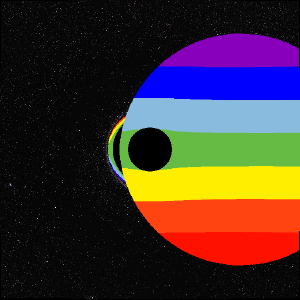

In [51]:
# %%
### Cell 5: Execute the Image Generation
# This cell calls the main function with your desired parameters.
# Modify the file paths and settings here to match your project.

# --- Parameters ---
output_file = "lensed_image.png"
blueprint_file = "blueprint.bin" # Or "demo_blueprint.bin" if you ran the cell above
source_image = "rainbow.png"       # Or "demo_source.png"
sphere_image = "starmap_2020.png"       # Or "demo_sphere.png"
source_image_width= 26.0
window_width= 2.0
blueprint_filename= "blueprint.bin"
# --- Call the function ---
# Ensure you have the necessary files (e.g., by running Cell 4 or using your own)
# For this example, we assume the demo files were created.
generate_lensed_image(
    output_filename="lensed_image_demo.png",
    output_pixel_width=300,
    source_image_width=source_image_width,
    sphere_image=sphere_image,
    source_image=source_image,
    blueprint_filename=blueprint_filename,
    window_width=window_width
)

# --- Display the result directly in the notebook ---
try:
    display(Image.open("lensed_image_demo.png"))
except NameError:
    # 'display' is not defined if not in a rich Ipython environment
    print("\nTo see the image, open 'lensed_image_demo.png' from the file explorer.")

--- Generating stacked radial histogram for 'blueprint.bin' ---


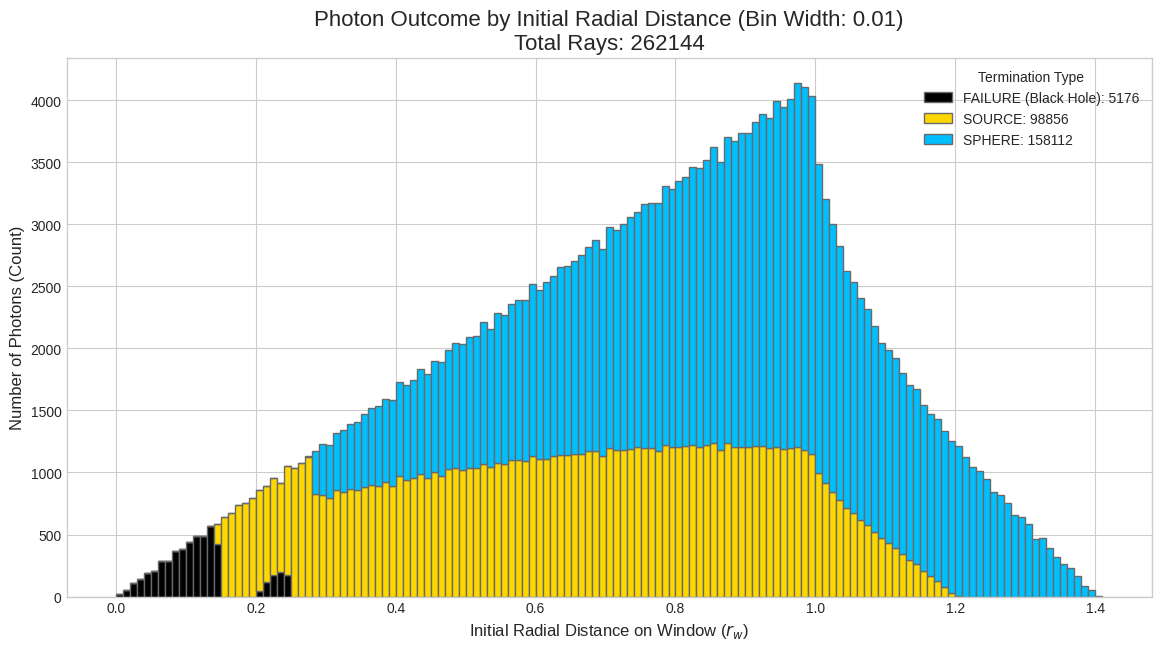

In [53]:
# %%
### Cell 8: Visualize Radial Distribution by Outcome (Stacked Histogram)
# This plot provides deep insight by showing the breakdown of where photons
# ended up (Black Hole, Source, Sphere) for each radial bin.

import matplotlib.pyplot as plt

def plot_stacked_radial_histogram(blueprint_filename: str, bin_width: float = 0.05):
    """
    Reads a blueprint file and creates a stacked histogram showing the
    outcome of photons as a function of their initial radial distance.

    Args:
        blueprint_filename: The path to the blueprint.bin file.
        bin_width: The width of each radial bin for the histogram.
    """
    print(f"--- Generating stacked radial histogram for '{blueprint_filename}' ---")
    
    # --- Load Data ---
    if not os.path.exists(blueprint_filename):
        print(f"Error: Blueprint file not found at '{blueprint_filename}'")
        return
        
    data = np.fromfile(blueprint_filename, dtype=BLUEPRINT_DTYPE)
    
    if len(data) == 0:
        print("Blueprint file is empty. Cannot generate plot.")
        return
        
    # --- Calculate r_w for all rays ---
    r_w = np.sqrt(data['y_w']**2 + data['z_w']**2)
    
    # --- Separate r_w values based on termination type ---
    mask_failure = (data['termination_type'] == 0)
    mask_source  = (data['termination_type'] == 1)
    mask_sphere  = (data['termination_type'] == 2)
    
    r_w_failure = r_w[mask_failure]
    r_w_source  = r_w[mask_source]
    r_w_sphere  = r_w[mask_sphere]
    
    # --- Create the Bins for the Histogram ---
    max_radius = r_w.max()
    bins = np.arange(0, max_radius + bin_width, bin_width)
    
    # --- Create the Plot ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Data and labels for the stacked histogram
    x_data = [r_w_failure, r_w_source, r_w_sphere]
    labels = [
        f'FAILURE (Black Hole): {len(r_w_failure)}',
        f'SOURCE: {len(r_w_source)}',
        f'SPHERE: {len(r_w_sphere)}'
    ]
    colors = ['black', 'gold', 'deepskyblue']
    
    # Create the stacked histogram
    ax.hist(x_data, bins=bins, stacked=True, label=labels, color=colors, edgecolor='dimgray')
    
    # --- Add Labels and Title ---
    title = f"Photon Outcome by Initial Radial Distance (Bin Width: {bin_width})\nTotal Rays: {len(data)}"
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Initial Radial Distance on Window ($r_w$)', fontsize=12)
    ax.set_ylabel('Number of Photons (Count)', fontsize=12)
    ax.legend(title='Termination Type')
    
    plt.show()


# --- Call the function with your blueprint file and desired bin width ---
plot_stacked_radial_histogram(blueprint_filename="blueprint.bin", bin_width=0.01)